In [1]:
import os
import scipy
import nibabel as nib
from nilearn import plotting,image
from nilearn.datasets import fetch_atlas_schaefer_2018
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import resample_to_img
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.layers import Conv3D, MaxPooling3D,MaxPooling1D, Flatten, Dense, LSTM,Dropout,Input,Conv3DTranspose,TimeDistributed,Conv1D
from tensorflow.keras.losses import CategoricalCrossentropy,MeanSquaredError
from tensorflow.keras.losses import SparseCategoricalCrossentropy as SparseCategoricalCrossentropyV1
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.metrics import Accuracy,CategoricalAccuracy,SparseCategoricalAccuracy
from tensorflow.keras.models import Model,Sequential
import tensorflow.keras.backend as K
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.callbacks import History, EarlyStopping
import seaborn as sns
from scipy.ndimage import zoom
from mayavi import mlab
import PyQt5

C:\Users\Cognition\anaconda3\envs\rantehila\lib\site-packages\nilearn\input_data\__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


## Defining the schaefer atlas

In [11]:
atlas = fetch_atlas_schaefer_2018(n_rois=200,resolution_mm=2)
atlas_filename = atlas.maps
atlas_labels = atlas.labels
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize='zscore_sample')

In [12]:
img = nib.load(r'C:\Users\Cognition\Desktop\swau002.nii')

In [13]:
img2 = nib.load(r'C:\Users\Cognition\Desktop\swau003.nii')

In [14]:
img.shape , img2.shape

((91, 109, 91, 140), (91, 109, 91, 197))

In [15]:
img_data = img.get_fdata()
img_data2 = img2.get_fdata()

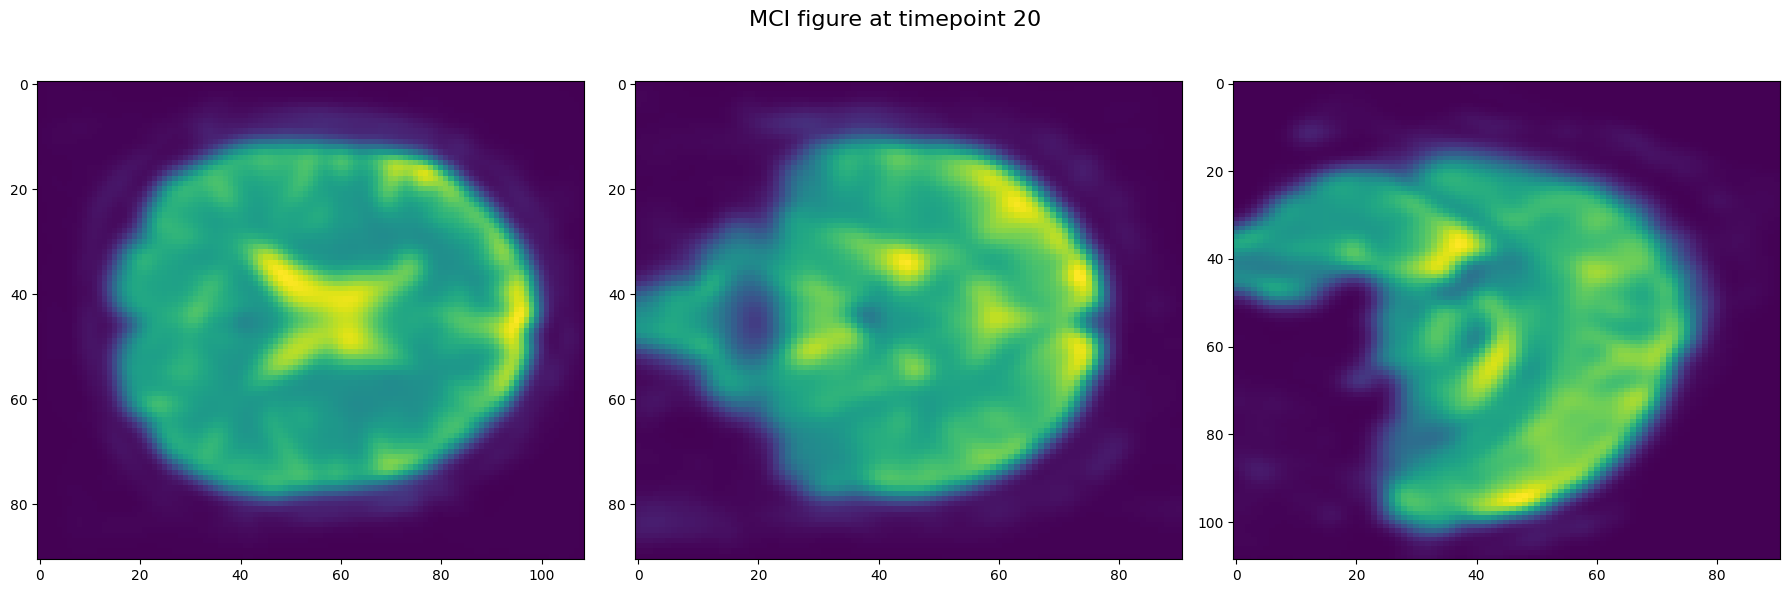

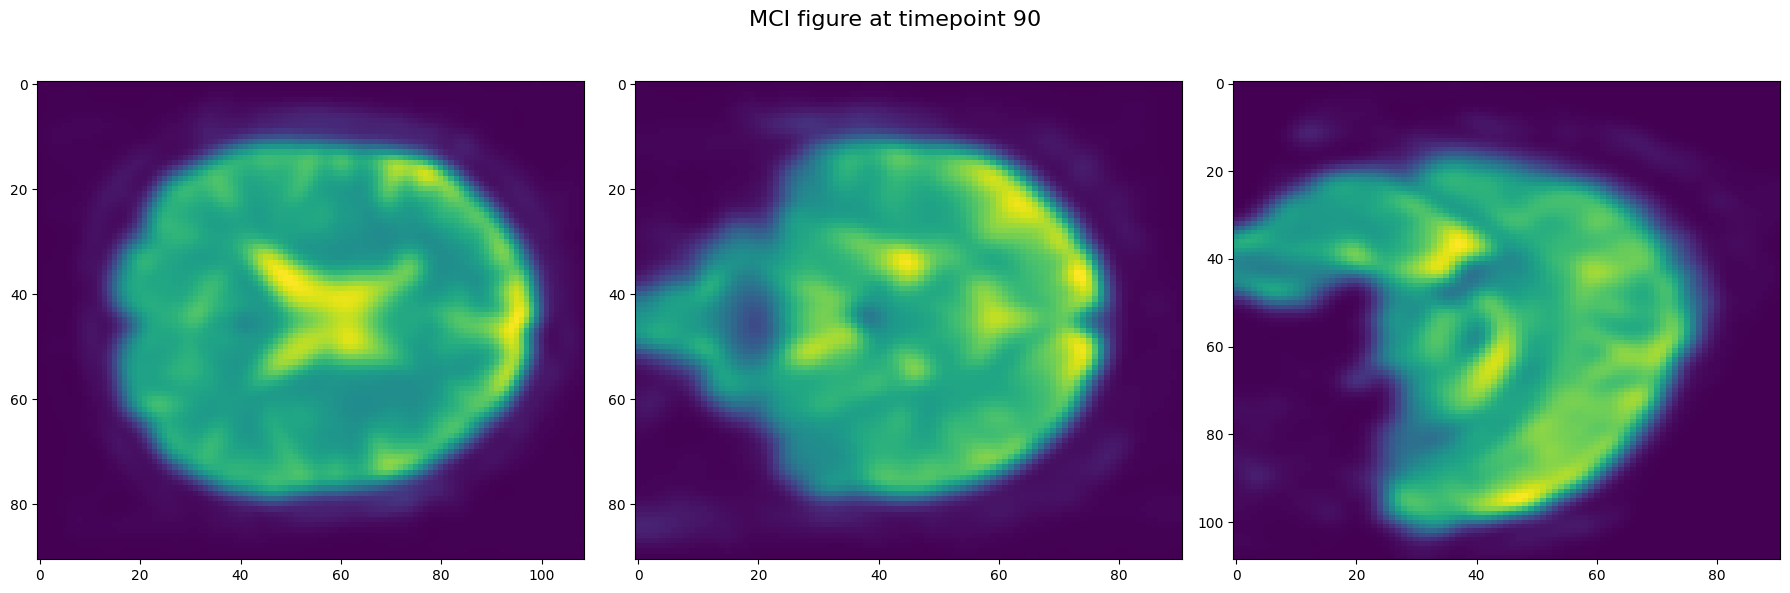

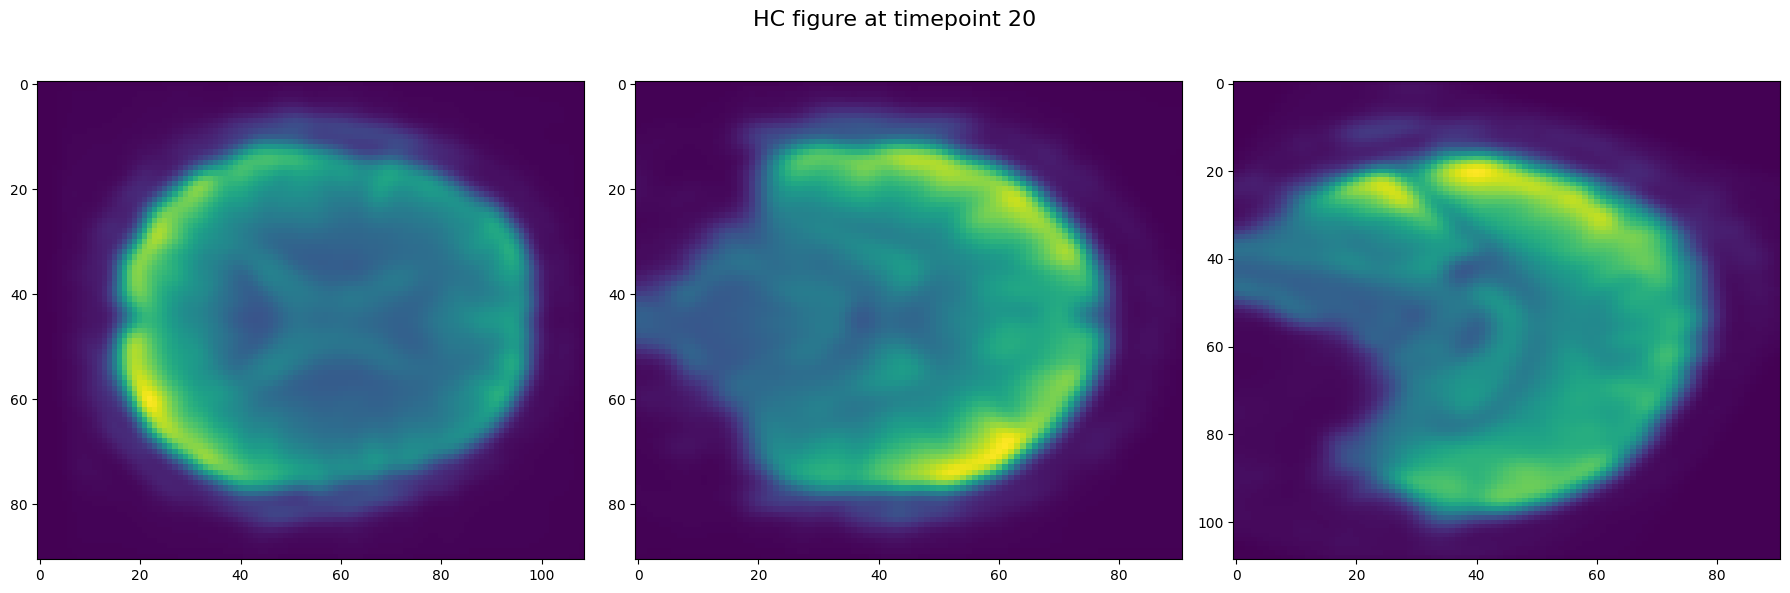

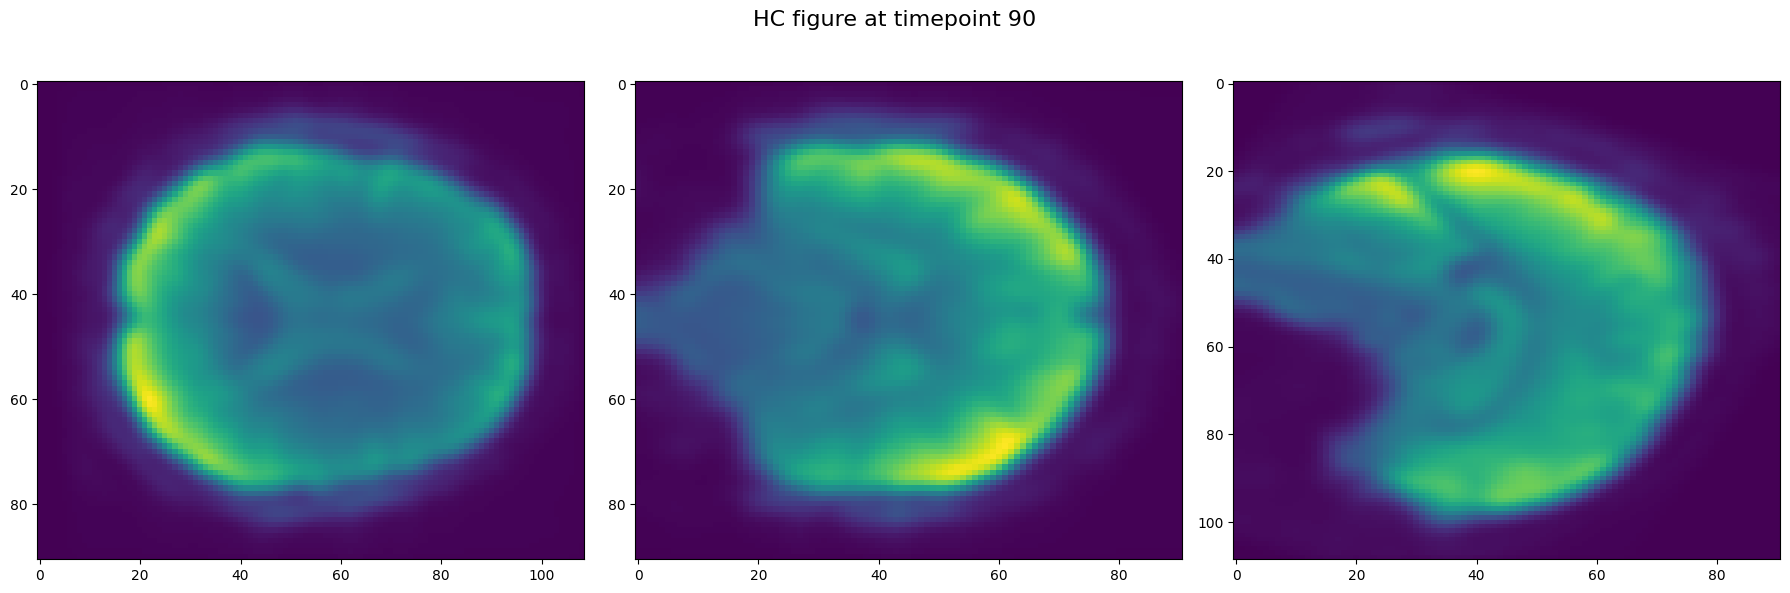

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(img_data[:,:,45,20], aspect='auto')
axes[1].imshow(img_data[:,45,:,20], aspect='auto')
axes[2].imshow(img_data[45,:,:,20], aspect='auto')

fig.suptitle('MCI figure at timepoint 20', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(img_data[:,:,45,90], aspect='auto')
axes[1].imshow(img_data[:,45,:,90], aspect='auto')
axes[2].imshow(img_data[45,:,:,90], aspect='auto')

fig.suptitle('MCI figure at timepoint 90', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()



fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(img_data2[:,:,45,20], aspect='auto')
axes[1].imshow(img_data2[:,45,:,20], aspect='auto')
axes[2].imshow(img_data2[45,:,:,20], aspect='auto')

fig.suptitle('HC figure at timepoint 20', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(img_data2[:,:,45,90], aspect='auto')
axes[1].imshow(img_data2[:,45,:,90], aspect='auto')
axes[2].imshow(img_data2[45,:,:,90], aspect='auto')

fig.suptitle('HC figure at timepoint 90', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

In [17]:
folder_path = 'D:\Tehila_Ran_Data\processed_hc'
HC=[]
HC_fmri = []
HC_series=[]
fmri_labels_HC = []
for root, dirs, files in os.walk(folder_path):
    for filename in files:
        if filename.endswith('.nii') and filename.startswith('swau'):  
            image_path = os.path.join(root, filename)
            img = nib.load(image_path)
            if img.shape[3]>=140:
                img_data = img.get_fdata()

                sliced_img_data = img_data[:, :, :, :140]

                sliced_img = nib.Nifti1Image(sliced_img_data, affine=img.affine)
                series=masker.fit_transform(sliced_img)
                HC_series.append(series[1:,:])
                
                mean_img = image.mean_img(sliced_img)
                HC.append(mean_img)
                resampled_atlas = image.resample_to_img(atlas_filename, mean_img, interpolation='continuous')
                img_data_new=resampled_atlas.get_fdata()

                HC_fmri.append(img_data_new)
                fmri_labels_HC.append(0)

In [18]:
HC_series[1].shape

(139, 200)

In [19]:
folder_path = 'D:\Tehila_Ran_Data\processed_mci'
MCI=[]
MCI_fmri = []
MCI_series=[]
fmri_labels_MCI = []
for root, dirs, files in os.walk(folder_path):
    for filename in files:
        if filename.endswith('.nii') and filename.startswith('swau'):  
            image_path = os.path.join(root, filename)
            img = nib.load(image_path)
            if img.shape[3]>=140:
                img_data = img.get_fdata()

                sliced_img_data = img_data[:, :, :, :140]

                sliced_img = nib.Nifti1Image(sliced_img_data, affine=img.affine)
                series=masker.fit_transform(sliced_img)
                MCI_series.append(series[1:,:])
                
                mean_img = image.mean_img(sliced_img)
                MCI.append(mean_img)
                resampled_atlas = image.resample_to_img(atlas_filename, mean_img, interpolation='continuous')
                img_data_new=resampled_atlas.get_fdata()

                MCI_fmri.append(img_data_new)
                fmri_labels_MCI.append(1)

In [20]:
MCI_series[1].shape

(139, 200)

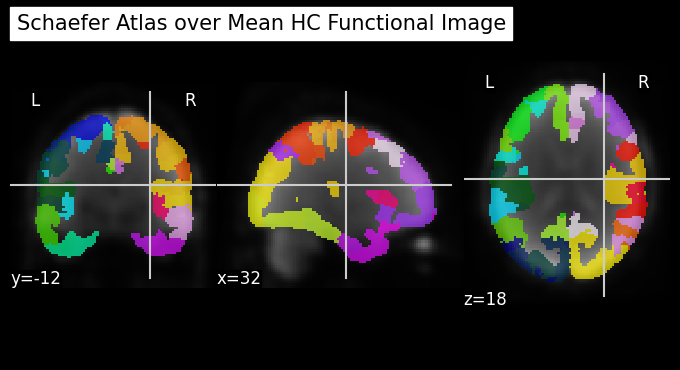

In [21]:
# Resample the atlas to match the mean functional image
resampled_atlas = image.resample_to_img(atlas_filename, HC[25], interpolation='nearest')

# Plot the atlas ROIs overlaid on the mean functional image
plotting.plot_roi(resampled_atlas, bg_img=HC[25], title='Schaefer Atlas over Mean HC Functional Image')

# Show the plot
plotting.show()

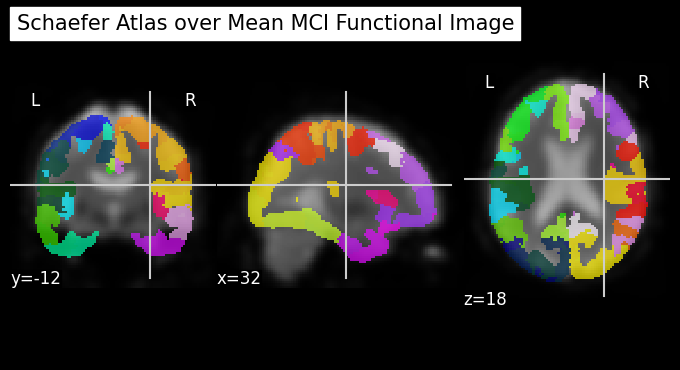

In [22]:
# Resample the atlas to match the mean functional image
resampled_atlas = image.resample_to_img(atlas_filename, MCI[25], interpolation='nearest')

# Plot the atlas ROIs overlaid on the mean functional image
plotting.plot_roi(resampled_atlas, bg_img=MCI[25], title='Schaefer Atlas over Mean MCI Functional Image')

# Show the plot
plotting.show()

In [23]:
i,j,z=0,20,45

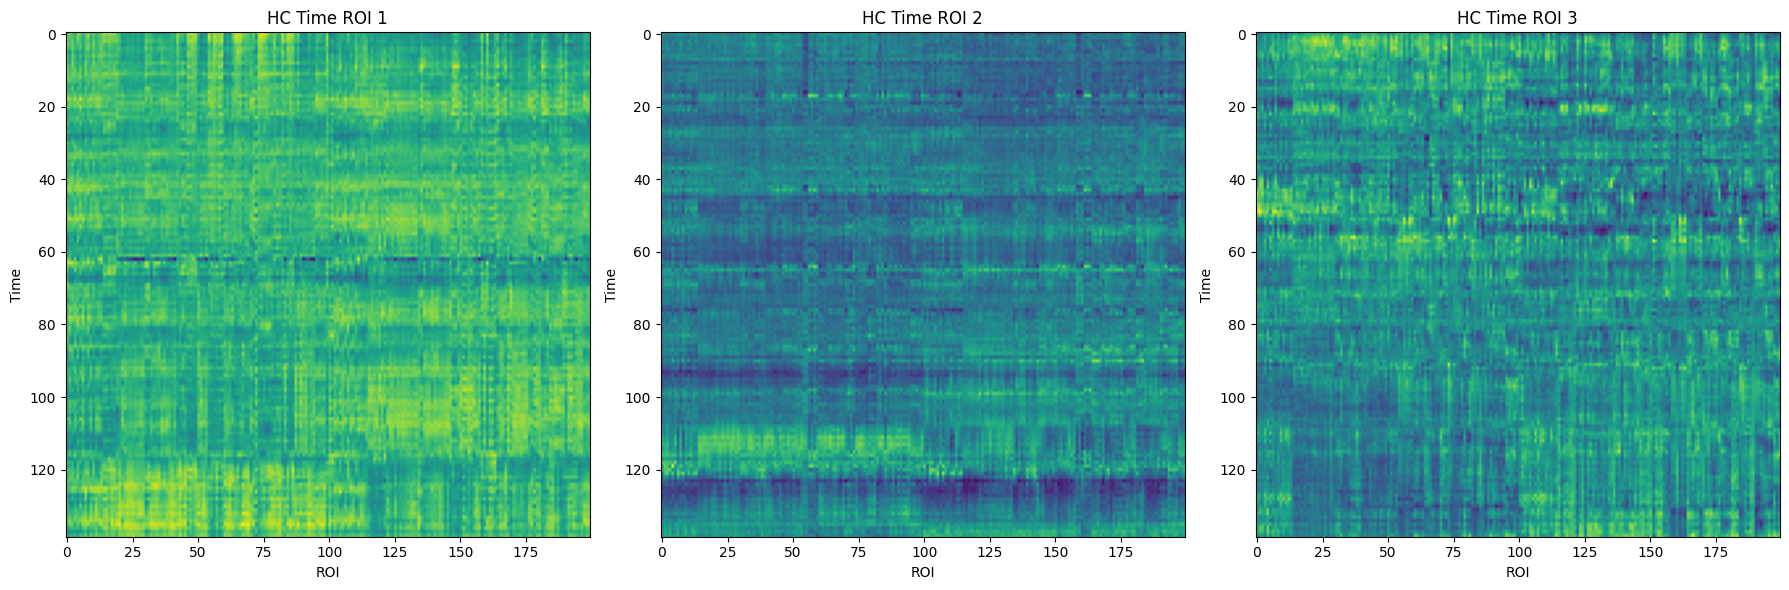

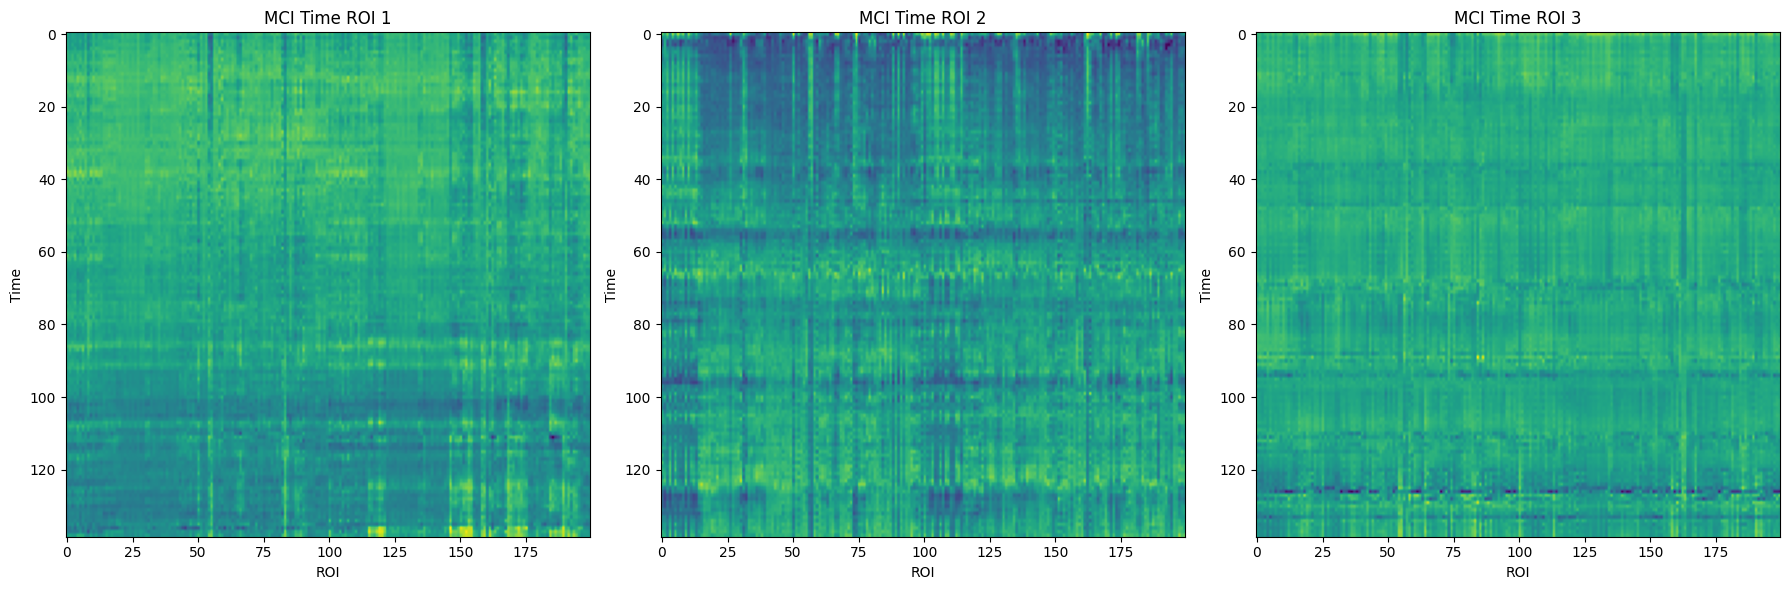

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the first time series as an image
axes[0].imshow(HC_series[i], aspect='auto')
axes[0].set_title('HC Time ROI 1')
axes[0].set_xlabel('ROI')
axes[0].set_ylabel('Time')

# Plot the second time series as an image
axes[1].imshow(HC_series[j], aspect='auto')
axes[1].set_title('HC Time ROI 2')
axes[1].set_xlabel('ROI')
axes[1].set_ylabel('Time')

# Plot the third time series as an image
axes[2].imshow(HC_series[z], aspect='auto')
axes[2].set_title('HC Time ROI 3')
axes[2].set_xlabel('ROI')
axes[2].set_ylabel('Time')

# Adjust layout to make space for the titles
plt.tight_layout()

# Display the plots
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the first time series as an image
axes[0].imshow(MCI_series[i], aspect='auto')
axes[0].set_title('MCI Time ROI 1')
axes[0].set_xlabel('ROI')
axes[0].set_ylabel('Time')

# Plot the second time series as an image
axes[1].imshow(MCI_series[j], aspect='auto')
axes[1].set_title('MCI Time ROI 2')
axes[1].set_xlabel('ROI')
axes[1].set_ylabel('Time')

# Plot the third time series as an image
axes[2].imshow(MCI_series[z], aspect='auto')
axes[2].set_title('MCI Time ROI 3')
axes[2].set_xlabel('ROI')
axes[2].set_ylabel('Time')

# Adjust layout to make space for the titles
plt.tight_layout()

# Display the plots
plt.show()


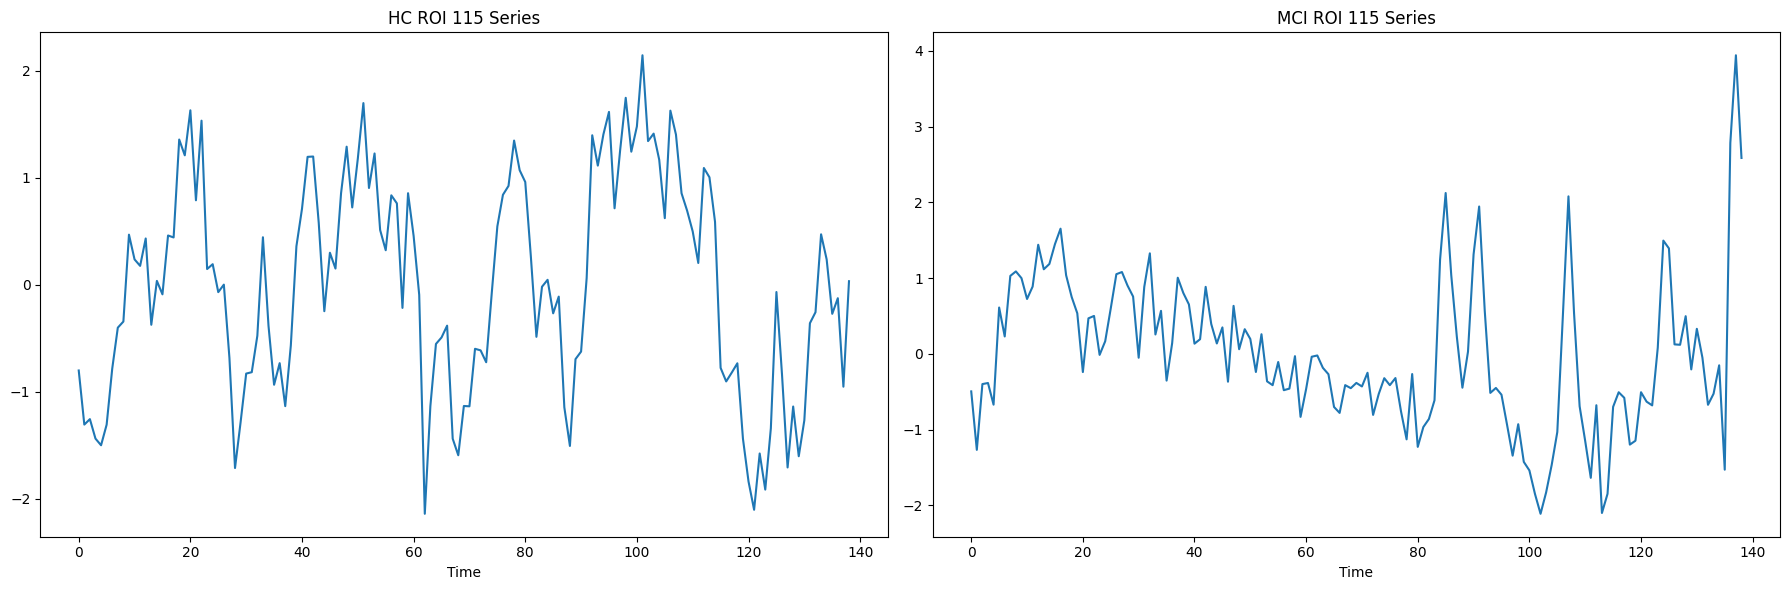

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the first time series as an image
axes[0].plot(HC_series[i][:,115])
axes[0].set_title('HC ROI 115 Series')
axes[0].set_xlabel('Time')

# Plot the second time series as an image
axes[1].plot(MCI_series[i][:,115])
axes[1].set_title('MCI ROI 115 Series')
axes[1].set_xlabel('Time')


# Adjust layout to make space for the titles
plt.tight_layout()

# Display the plots
plt.show()

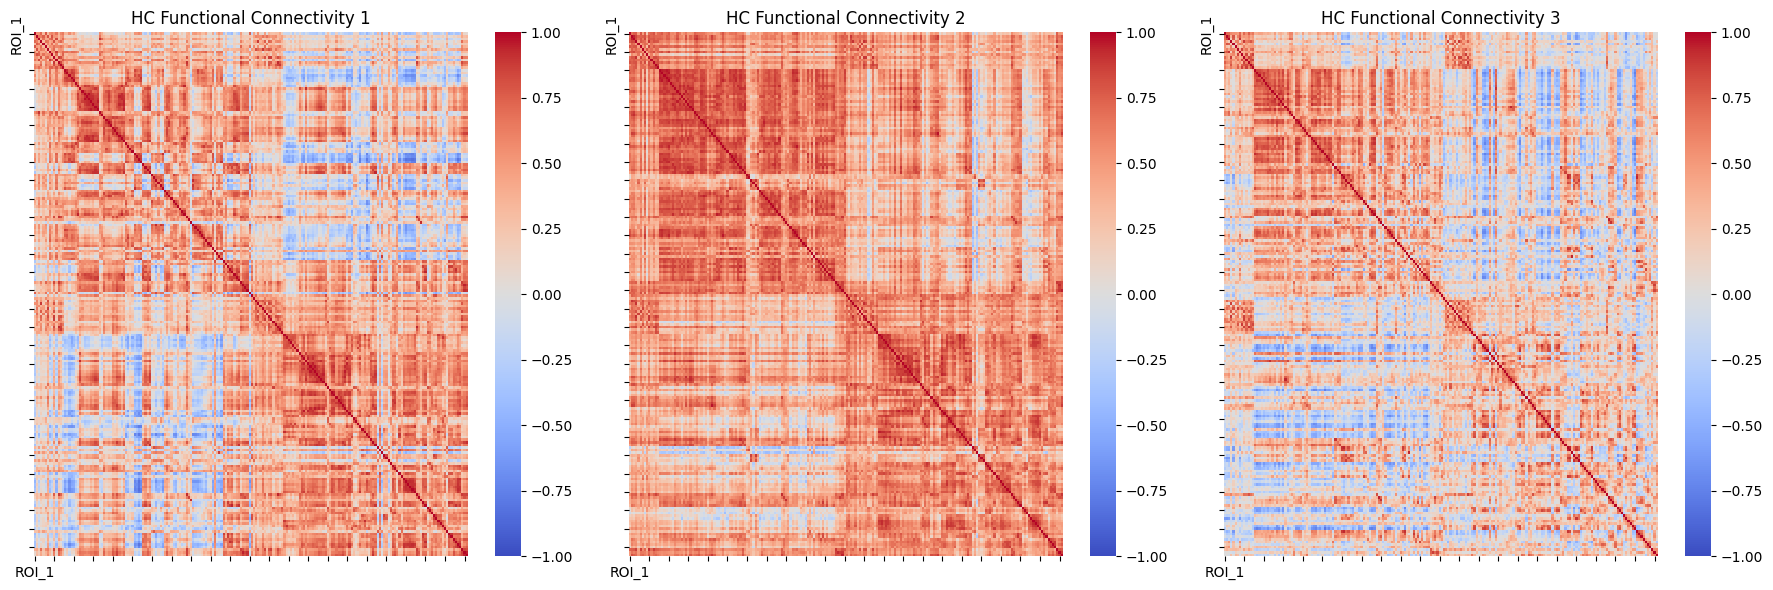

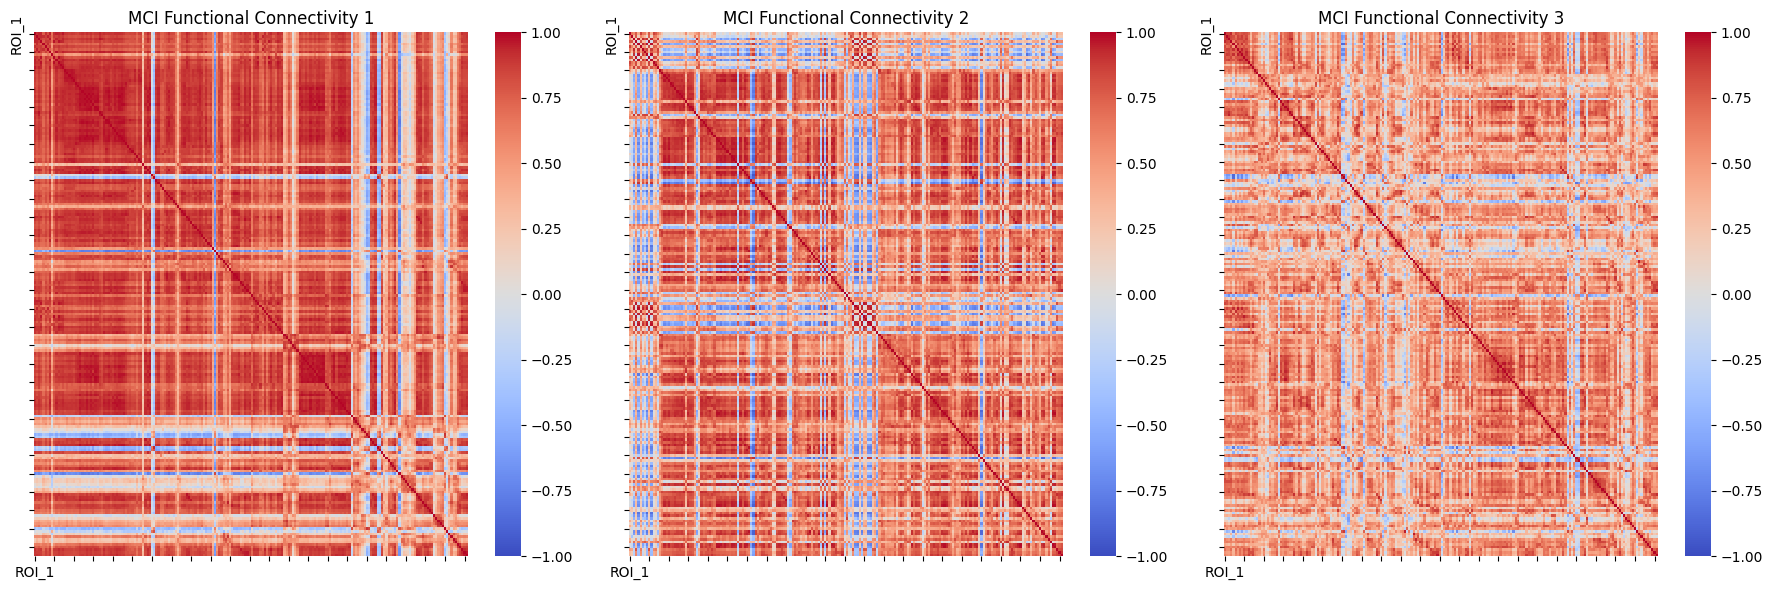

In [48]:
df1 = pd.DataFrame(HC_series[i])
df1.columns = [f'ROI_{i+1}' if (i==0 or i==199) else '' for i in range(HC_series[i].shape[1])]
df2 = pd.DataFrame(HC_series[j])
df2.columns = [f'ROI_{i+1}' if (i==0 or i==199) else '' for i in range(HC_series[j].shape[1])]
df3 = pd.DataFrame(HC_series[z])
df3.columns = [f'ROI_{i+1}' if (i==0 or i==199) else '' for i in range(HC_series[z].shape[1])]

# Calculate the correlation matrices
correlation_matrix1 = df1.corr()
correlation_matrix2 = df2.corr()
correlation_matrix3 = df3.corr()

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 3, figsize=(18,6))

# Plot the first correlation matrix
sns.heatmap(correlation_matrix1, ax=axes[0], cmap='coolwarm', vmin=-1, vmax=1)
axes[0].set_title('HC Functional Connectivity 1')

# Plot the second correlation matrix
sns.heatmap(correlation_matrix2, ax=axes[1], cmap='coolwarm', vmin=-1, vmax=1)
axes[1].set_title('HC Functional Connectivity 2')

# Plot the third correlation matrix
sns.heatmap(correlation_matrix3, ax=axes[2], cmap='coolwarm', vmin=-1, vmax=1)
axes[2].set_title('HC Functional Connectivity 3')

# Adjust layout to make space for the titles
plt.tight_layout()

df1 = pd.DataFrame(MCI_series[i])
df1.columns = [f'ROI_{i+1}' if (i==0 or i==100 or i==199) else '' for i in range(MCI_series[i].shape[1])]
df2 = pd.DataFrame(MCI_series[j])
df2.columns = [f'ROI_{i+1}' if (i==0 or i==100 or i==199) else '' for i in range(MCI_series[j].shape[1])]
df3 = pd.DataFrame(MCI_series[z])
df3.columns = [f'ROI_{i+1}' if (i==0 or i==100 or i==199) else '' for i in range(MCI_series[z].shape[1])]

# Calculate the correlation matrices
correlation_matrix1 = df1.corr()
correlation_matrix2 = df2.corr()
correlation_matrix3 = df3.corr()

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the first correlation matrix
sns.heatmap(correlation_matrix1, ax=axes[0], cmap='coolwarm', vmin=-1, vmax=1)
axes[0].set_title('MCI Functional Connectivity 1')

# Plot the second correlation matrix
sns.heatmap(correlation_matrix2, ax=axes[1], cmap='coolwarm', vmin=-1, vmax=1)
axes[1].set_title('MCI Functional Connectivity 2')

# Plot the third correlation matrix
sns.heatmap(correlation_matrix3, ax=axes[2], cmap='coolwarm', vmin=-1, vmax=1)
axes[2].set_title('MCI Functional Connectivity 3')

# Adjust layout to make space for the titles
plt.tight_layout()

In [380]:
HC_series = np.array(HC_series)
MCI_series = np.array(MCI_series)
#fmri_labels_HC = np.array(fmri_labels_HC)
#fmri_labels_MCI = np.array(fmri_labels_MCI)

In [381]:
fmri_features = np.concatenate((HC_series, MCI_series), axis=0)

In [382]:
fmri_labels = np.concatenate((fmri_labels_HC, fmri_labels_MCI), axis=0)

In [383]:
print("Shape of all_fmri:", fmri_features.shape)
print("Shape of all_labels:", fmri_labels.shape)

Shape of all_fmri: (154, 139, 200)
Shape of all_labels: (154,)


In [384]:
x_size,y_size = fmri_features[1].shape[0],fmri_features[1].shape[1]
input_shape = (x_size,y_size,1)
num_classes = 2
input_shape

(139, 200, 1)

In [533]:
x_train, x_te, y_train, y_te = train_test_split(fmri_features,fmri_labels,test_size=0.3,stratify=fmri_labels)
x_val, x_test, y_val, y_test = train_test_split(x_te,y_te,test_size=0.5,stratify=y_te)

### Vistransformer

In [407]:
inputs = keras.Input(shape=input_shape)

x = layers.Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(inputs)
x = layers.BatchNormalization()(x)

embedding_dim = 128  # Embedding dimension
num_heads = 1  # Number of attention heads
transformer_units = [(embedding_dim * 2), (embedding_dim)]  # Feedforward network units
num_transformer_blocks = 1  # Adjust as needed

for _ in range(num_transformer_blocks):
    # Multi-head self-attention
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(x, x, x)
    attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output + x)

    # Feedforward network
    feedforward_output = layers.Conv2D(transformer_units[0], kernel_size=1, activation="relu")(attention_output)
    feedforward_output = layers.Conv2D(transformer_units[1], kernel_size=1)(feedforward_output)
    x = layers.LayerNormalization(epsilon=1e-6)(attention_output + feedforward_output)

x = layers.GlobalMaxPooling2D()(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.models.Model(inputs=inputs, outputs=outputs)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [408]:
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_23 (InputLayer)       [(None, 139, 200, 1)]        0         []                            
                                                                                                  
 conv2d_48 (Conv2D)          (None, 70, 100, 128)         1280      ['input_23[0][0]']            
                                                                                                  
 batch_normalization_9 (Bat  (None, 70, 100, 128)         512       ['conv2d_48[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 multi_head_attention_9 (Mu  (None, 70, 100, 128)         66048     ['batch_normalization_9

In [409]:
history_callback = History()
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val),callbacks=[history_callback, early_stopping])
train_loss_values = history.history['loss']
train_acc_values = history.history['accuracy']
val_loss_values = history.history['val_loss']
val_acc_values = history.history['val_accuracy']


# Evaluate the model on the test set
val_loss, val_accuracy =  model.evaluate(x_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/100
4/4 [==============================] - 48s 11s/step - loss: 1.3225 - accuracy: 0.5327 - val_loss: 3.0388 - val_accuracy: 0.5652
Epoch 2/100
4/4 [==============================] - 47s 11s/step - loss: 1.3202 - accuracy: 0.6355 - val_loss: 3.6487 - val_accuracy: 0.5652
Epoch 3/100
4/4 [==============================] - 47s 11s/step - loss: 0.3328 - accuracy: 0.8411 - val_loss: 2.0782 - val_accuracy: 0.6522
Epoch 4/100
4/4 [==============================] - 47s 11s/step - loss: 0.5498 - accuracy: 0.7477 - val_loss: 2.9965 - val_accuracy: 0.5652
Epoch 5/100
4/4 [==============================] - 47s 11s/step - loss: 0.1840 - accuracy: 0.9346 - val_loss: 3.5266 - val_accuracy: 0.5652
Epoch 6/100
4/4 [==============================] - 47s 11s/step - loss: 0.2129 - accuracy: 0.9252 - val_loss: 3.4609 - val_accuracy: 0.6087
Epoch 7/100
4/4 [==============================] - 47s 11s/step - loss: 0.2145 - accuracy: 0.9346 - val_loss: 3.3921 - val_accuracy: 0.6522
Epoch 8/100
4/4 [===

1/1 [==============================] - 5s 5s/step


<Axes: >

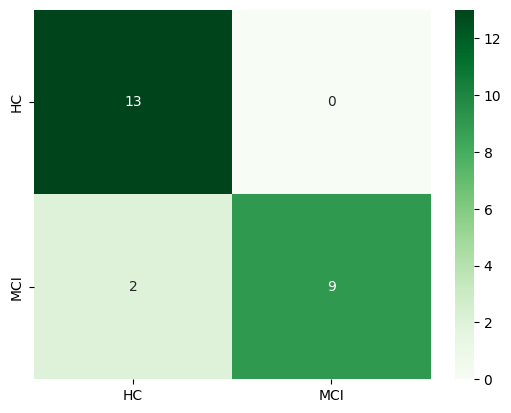

In [410]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
df = pd.DataFrame(data = confusion_matrix(y_test, predictions),
  columns = ['HC','MCI'],
  index = ['HC','MCI'])
sns.heatmap(df, cmap="Greens", annot=True, fmt='.0f')

<Axes: >

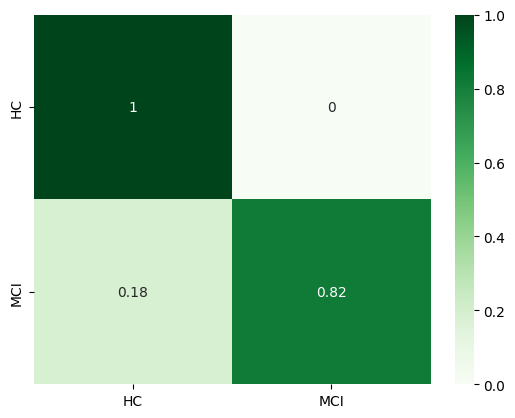

In [411]:
mat = confusion_matrix(y_test, predictions)
df =pd.DataFrame((mat/mat.sum(axis = 1,keepdims = True)).round(2), columns =['HC','MCI'],index = ['HC','MCI'])
sns.heatmap(df, cmap="Greens", annot=True)

1/1 [==============================] - 4s 4s/step


<Axes: >

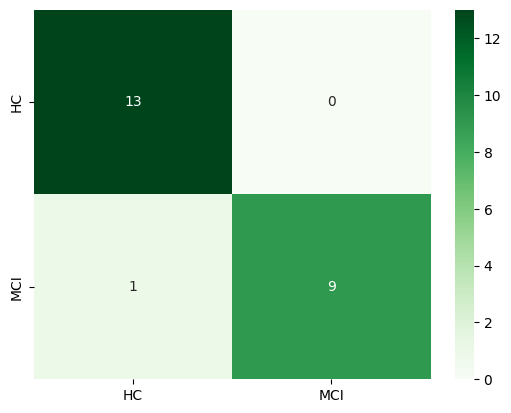

In [412]:
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
df = pd.DataFrame(data = confusion_matrix(y_val, predictions),
  columns = ['HC','MCI'],
  index = ['HC','MCI'])
sns.heatmap(df, cmap="Greens", annot=True, fmt='.0f')

<Axes: >

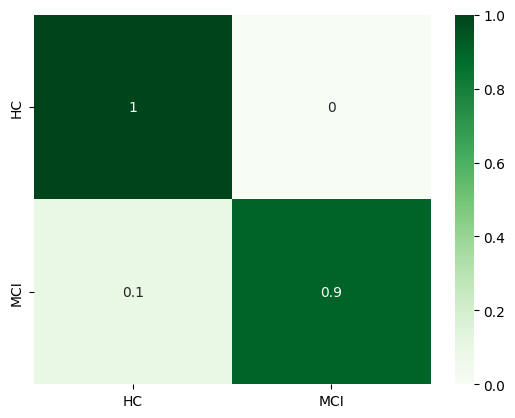

In [413]:
mat = confusion_matrix(y_val, predictions)
df =pd.DataFrame((mat/mat.sum(axis = 1,keepdims = True)).round(2), columns = ['HC','MCI'],index = ['HC','MCI'])
sns.heatmap(df, cmap="Greens", annot=True)

In [414]:
epochs_applied = early_stopping.stopped_epoch + 1
if epochs_applied<20:
    epochs_applied=100

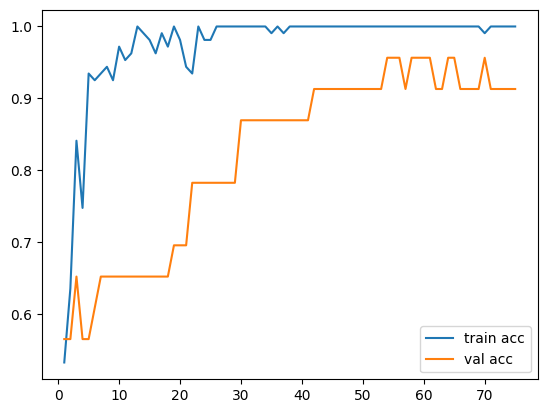

In [422]:
lenx = [i+1 for i in range(epochs_applied)]
plt.plot(lenx, train_acc_values, label = "train acc")
plt.plot(lenx, val_acc_values, label = "val acc")
plt.legend()
plt.show()

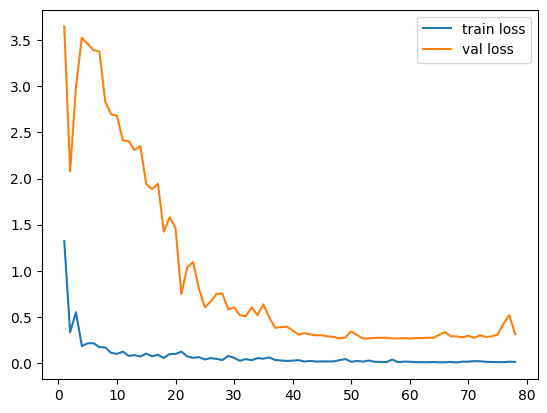

In [417]:
lenx = [i+1 for i in range(epochs_applied-1)]
plt.plot(lenx, train_loss_values[1:],label = "train loss")
plt.plot(lenx, val_loss_values[1:], label = "val loss")
plt.legend()
plt.show()

In [822]:
K.clear_session()

### CNN 2D

In [865]:
inputs = keras.Input(shape=input_shape)

# Convolutional layers for local feature extraction
x = layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(inputs)
x = layers.Dropout(0.2)(x)  
x = layers.Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(x)
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dense(128, activation='relu')(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.models.Model(inputs=inputs, outputs=outputs)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [866]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 139, 200, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 70, 100, 64)       640       
                                                                 
 dropout (Dropout)           (None, 70, 100, 64)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 35, 50, 32)        18464     
                                                                 
 global_max_pooling2d (Glob  (None, 32)                0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                             

In [867]:
history_callback = History()
early_stopping = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=500, validation_data=(x_val, y_val),callbacks=[history_callback, early_stopping])
train_loss_values = history.history['loss']
train_acc_values = history.history['accuracy']
val_loss_values = history.history['val_loss']
val_acc_values = history.history['val_accuracy']


# Evaluate the model on the test set
val_loss, val_accuracy =  model.evaluate(x_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/500
4/4 [==============================] - 1s 117ms/step - loss: 0.6943 - accuracy: 0.4766 - val_loss: 0.6770 - val_accuracy: 0.5652
Epoch 2/500
4/4 [==============================] - 0s 68ms/step - loss: 0.6631 - accuracy: 0.5514 - val_loss: 0.6678 - val_accuracy: 0.5652
Epoch 3/500
4/4 [==============================] - 0s 67ms/step - loss: 0.6466 - accuracy: 0.6355 - val_loss: 0.6599 - val_accuracy: 0.7391
Epoch 4/500
4/4 [==============================] - 0s 70ms/step - loss: 0.6139 - accuracy: 0.7290 - val_loss: 0.6409 - val_accuracy: 0.7391
Epoch 5/500
4/4 [==============================] - 0s 68ms/step - loss: 0.5965 - accuracy: 0.6542 - val_loss: 0.6211 - val_accuracy: 0.7391
Epoch 6/500
4/4 [==============================] - 0s 68ms/step - loss: 0.5714 - accuracy: 0.7850 - val_loss: 0.6120 - val_accuracy: 0.8261
Epoch 7/500
4/4 [==============================] - 0s 77ms/step - loss: 0.5338 - accuracy: 0.8692 - val_loss: 0.5797 - val_accuracy: 0.7826
Epoch 8/500
4/4 [==

1/1 [==============================] - 0s 60ms/step


<Axes: >

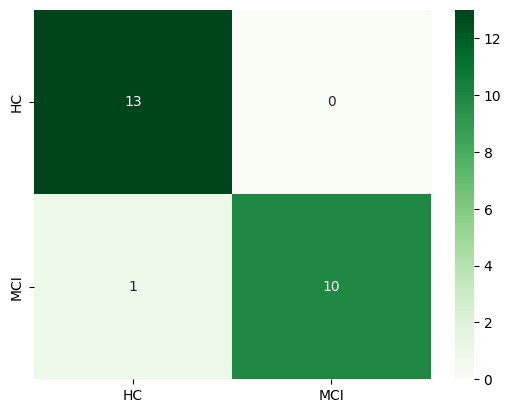

In [868]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
df = pd.DataFrame(data = confusion_matrix(y_test, predictions),
  columns = ['HC','MCI'],
  index = ['HC','MCI'])
sns.heatmap(df, cmap="Greens", annot=True, fmt='.0f')

<Axes: >

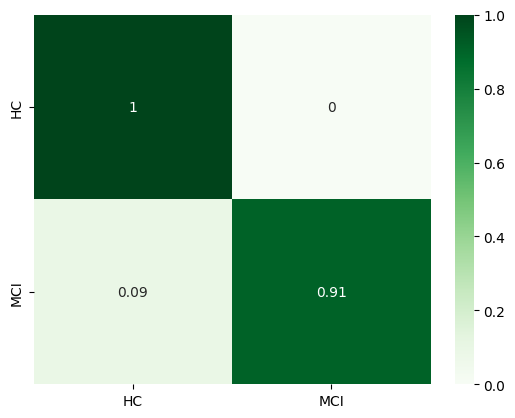

In [869]:
mat = confusion_matrix(y_test, predictions)
df =pd.DataFrame((mat/mat.sum(axis = 1,keepdims = True)).round(2), columns = ['HC','MCI'],index = ['HC','MCI'])
sns.heatmap(df, cmap="Greens", annot=True)

1/1 [==============================] - 0s 24ms/step


<Axes: >

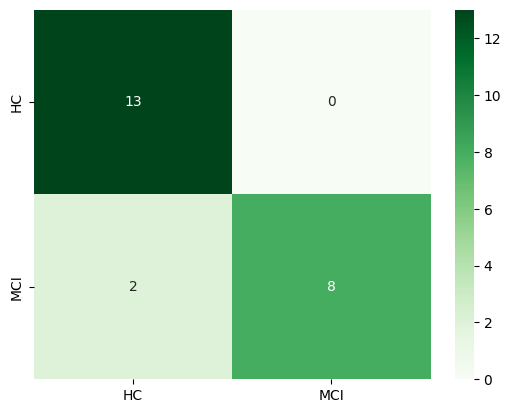

In [870]:
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
df = pd.DataFrame(data = confusion_matrix(y_val, predictions),
  columns = ['HC','MCI'],
  index = ['HC','MCI'])
sns.heatmap(df, cmap="Greens", annot=True, fmt='.0f')

<Axes: >

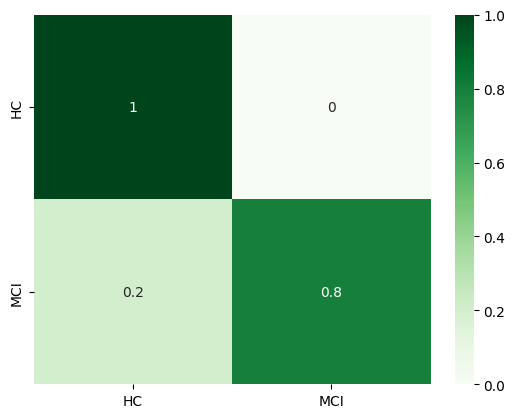

In [871]:
mat = confusion_matrix(y_val, predictions)
df =pd.DataFrame((mat/mat.sum(axis = 1,keepdims = True)).round(2), columns = ['HC','MCI'],index = ['HC','MCI'])
sns.heatmap(df, cmap="Greens", annot=True)

In [872]:
epochs_applied = early_stopping.stopped_epoch + 1
if epochs_applied<50:
    epochs_applied=500

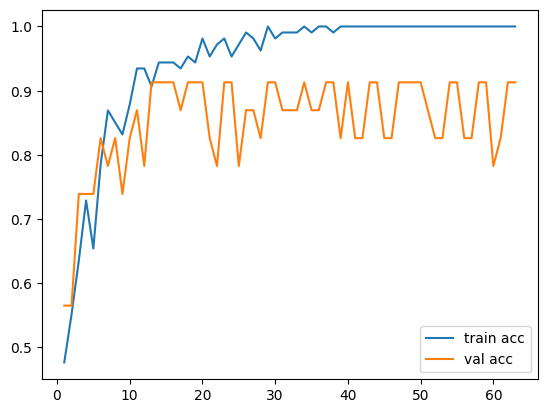

In [873]:
lenx = [i+1 for i in range(epochs_applied)]
plt.plot(lenx, train_acc_values, label = "train acc")
plt.plot(lenx, val_acc_values, label = "val acc")
plt.legend()
plt.show()

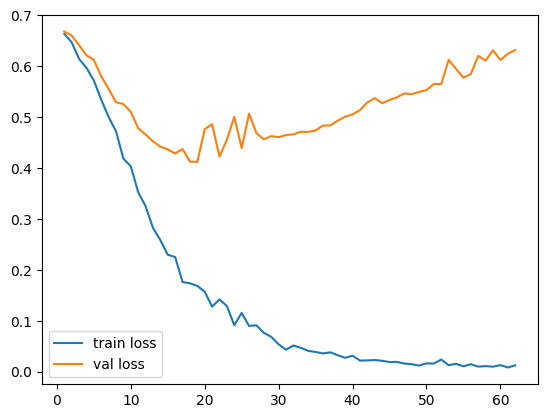

In [874]:
lenx = [i+1 for i in range(epochs_applied-1)]
plt.plot(lenx, train_loss_values[1:],label = "train loss")
plt.plot(lenx, val_loss_values[1:], label = "val loss")
plt.legend()
plt.show()

In [864]:
K.clear_session()

### LSTM

In [881]:
input_shape_lstm = (x_size,y_size)

model = Sequential()

# LSTM layers
model.add(LSTM(139, activation='relu', input_shape=input_shape_lstm, return_sequences=True))
#model.add(Dropout(0.1))
model.add(LSTM(64, activation='relu', return_sequences=False))
#model.add(Dropout(0.1))

# Fully connected layers
model.add(Dense(64, activation='relu'))


# Output layer
model.add(Dense(2, activation='softmax'))  # Change the number of units according to your number of classes

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 139, 139)          189040    
                                                                 
 lstm_7 (LSTM)               (None, 64)                52224     
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 2)                 130       
                                                                 
Total params: 245554 (959.20 KB)
Trainable params: 245554 (959.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [882]:
history_callback = History()
early_stopping = EarlyStopping(monitor='val_accuracy', patience=100, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=500, validation_data=(x_val, y_val),callbacks=[history_callback, early_stopping])
train_loss_values = history.history['loss']
train_acc_values = history.history['accuracy']
val_loss_values = history.history['val_loss']
val_acc_values = history.history['val_accuracy']


# Evaluate the model on the test set
val_loss, val_accuracy =  model.evaluate(x_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/500
4/4 [==============================] - 2s 171ms/step - loss: 0.6748 - accuracy: 0.5888 - val_loss: 0.6681 - val_accuracy: 0.7826
Epoch 2/500
4/4 [==============================] - 0s 73ms/step - loss: 2.1444 - accuracy: 0.7383 - val_loss: 0.6938 - val_accuracy: 0.4348
Epoch 3/500
4/4 [==============================] - 0s 73ms/step - loss: 0.6937 - accuracy: 0.4486 - val_loss: 0.6939 - val_accuracy: 0.4348
Epoch 4/500
4/4 [==============================] - 0s 74ms/step - loss: 0.6938 - accuracy: 0.4486 - val_loss: 0.6939 - val_accuracy: 0.4348
Epoch 5/500
4/4 [==============================] - 0s 73ms/step - loss: 0.6937 - accuracy: 0.4486 - val_loss: 0.6936 - val_accuracy: 0.4348
Epoch 6/500
4/4 [==============================] - 0s 74ms/step - loss: 0.6935 - accuracy: 0.4486 - val_loss: 0.6934 - val_accuracy: 0.4348
Epoch 7/500
4/4 [==============================] - 0s 73ms/step - loss: 0.6933 - accuracy: 0.4486 - val_loss: 0.6932 - val_accuracy: 0.4348
Epoch 8/500
4/4 [==

1/1 [==============================] - 0s 230ms/step


<Axes: >

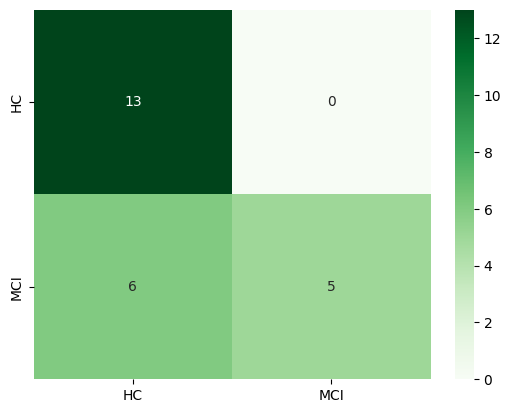

In [883]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
df = pd.DataFrame(data = confusion_matrix(y_test, predictions),
  columns = ['HC','MCI'],
  index = ['HC','MCI'])
sns.heatmap(df, cmap="Greens", annot=True, fmt='.0f')

<Axes: >

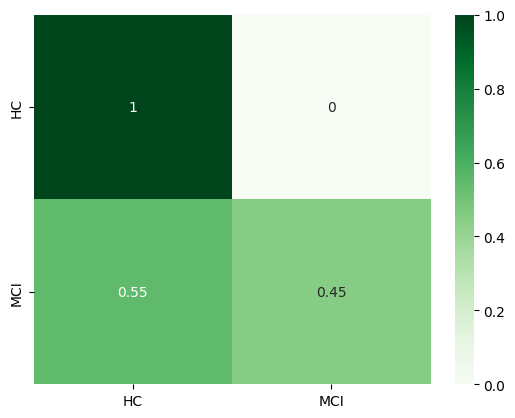

In [884]:
mat = confusion_matrix(y_test, predictions)
df =pd.DataFrame((mat/mat.sum(axis = 1,keepdims = True)).round(2), columns = ['HC','MCI'],index = ['HC','MCI'])
sns.heatmap(df, cmap="Greens", annot=True)

1/1 [==============================] - 0s 36ms/step


<Axes: >

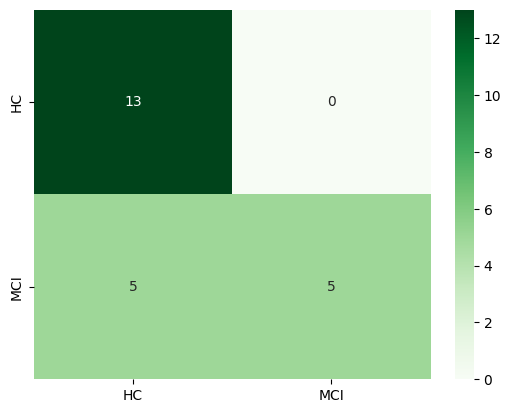

In [885]:
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
df = pd.DataFrame(data = confusion_matrix(y_val, predictions),
  columns = ['HC','MCI'],
  index = ['HC','MCI'])
sns.heatmap(df, cmap="Greens", annot=True, fmt='.0f')

<Axes: >

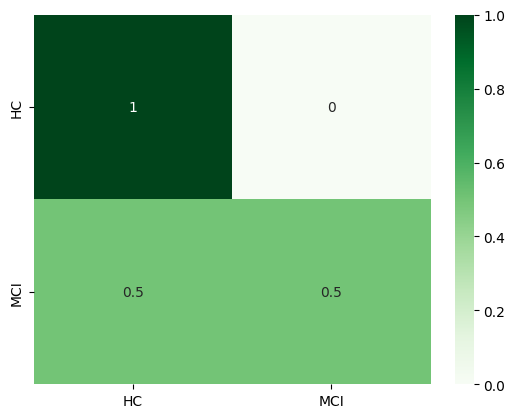

In [886]:
mat = confusion_matrix(y_val, predictions)
df =pd.DataFrame((mat/mat.sum(axis = 1,keepdims = True)).round(2), columns = ['HC','MCI'],index = ['HC','MCI'])
sns.heatmap(df, cmap="Greens", annot=True)

In [887]:
epochs_applied = early_stopping.stopped_epoch + 1
if epochs_applied<50:
    epochs_applied=500

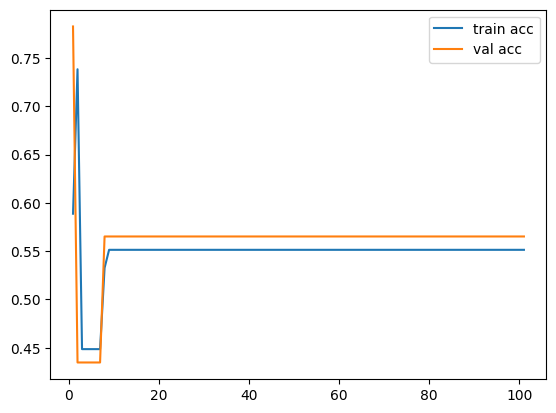

In [888]:
lenx = [i+1 for i in range(epochs_applied)]
plt.plot(lenx, train_acc_values, label = "train acc")
plt.plot(lenx, val_acc_values, label = "val acc")
plt.legend()
plt.show()

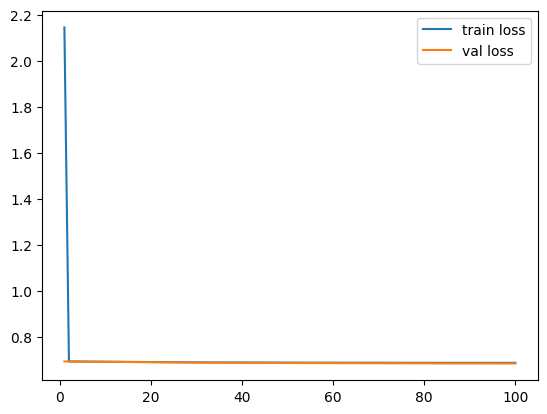

In [889]:
lenx = [i+1 for i in range(epochs_applied-1)]
plt.plot(lenx, train_loss_values[1:],label = "train loss")
plt.plot(lenx, val_loss_values[1:], label = "val loss")
plt.legend()
plt.show()

In [899]:
K.clear_session()

### 3D CNN model for anatomic data

In [54]:
folder_path = 'D:\Tehila_Ran_Data\processed_hc'
HC_3D=[]
HC_3D_fmri = []
mri_labels_HC = []
for root, dirs, files in os.walk(folder_path):
    for filename in files:
        if filename.endswith('.nii') and filename.startswith('wc0c'):  
            image_path = os.path.join(root, filename)
            img = nib.load(image_path)
            
            img_data = img.get_fdata()
            
            HC_3D.append(img)
            HC_3D_fmri.append(img_data)
            
            mri_labels_HC.append(0)

In [55]:
HC_3D_fmri[1].shape

(181, 217, 181)

In [56]:
folder_path = 'D:\Tehila_Ran_Data\processed_mci'
MCI_3D=[]
MCI_3D_fmri = []
mri_labels_MCI = []
for root, dirs, files in os.walk(folder_path):
    for filename in files:
        if filename.endswith('.nii') and filename.startswith('wc0c'):  
            image_path = os.path.join(root, filename)
            img = nib.load(image_path)
            
            img_data = img.get_fdata()
            
            MCI_3D.append(img)
            MCI_3D_fmri.append(img_data)
            
            mri_labels_MCI.append(1)

In [57]:
MCI_3D_fmri[1].shape

(181, 217, 181)

In [6]:
#mlab.figure(size=(250, 250), bgcolor=(0, 0, 0))
#src = mlab.pipeline.scalar_field(HC_3D_fmri[21])
#mlab.pipeline.iso_surface(src, contours=[HC_3D_fmri[21].min() + 0.1 * HC_3D_fmri[21].ptp(), ], opacity=0.3)
#mlab.pipeline.iso_surface(src, contours=[HC_3D_fmri[21].max() - 0.1 * HC_3D_fmri[21].ptp(), ],)
#mlab.show()

In [7]:
#mlab.figure(size=(250, 250), bgcolor=(0, 0, 0))
#src = mlab.pipeline.scalar_field(MCI_3D_fmri[21])
#mlab.pipeline.iso_surface(src, contours=[MCI_3D_fmri[21].min() + 0.1 * MCI_3D_fmri[21].ptp(), ], opacity=0.3)
#mlab.pipeline.iso_surface(src, contours=[MCI_3D_fmri[21].max() - 0.1 * MCI_3D_fmri[21].ptp(), ],)
#mlab.show()

In [58]:
target_shape = (100,108,100)  # Specify your desired shape here

# Initialize lists to store resized images
resized_HC_fmri = []
resized_MCI_fmri = []

# Resize images in CN_fmri
for img in HC_3D_fmri:
    resized_img = zoom(img, target_shape / np.array(img.shape), order=1)
    resized_HC_fmri.append(resized_img)

# Resize images in MCI_fmri
for img in MCI_3D_fmri:
    resized_img = zoom(img, target_shape / np.array(img.shape), order=1)
    resized_MCI_fmri.append(resized_img)


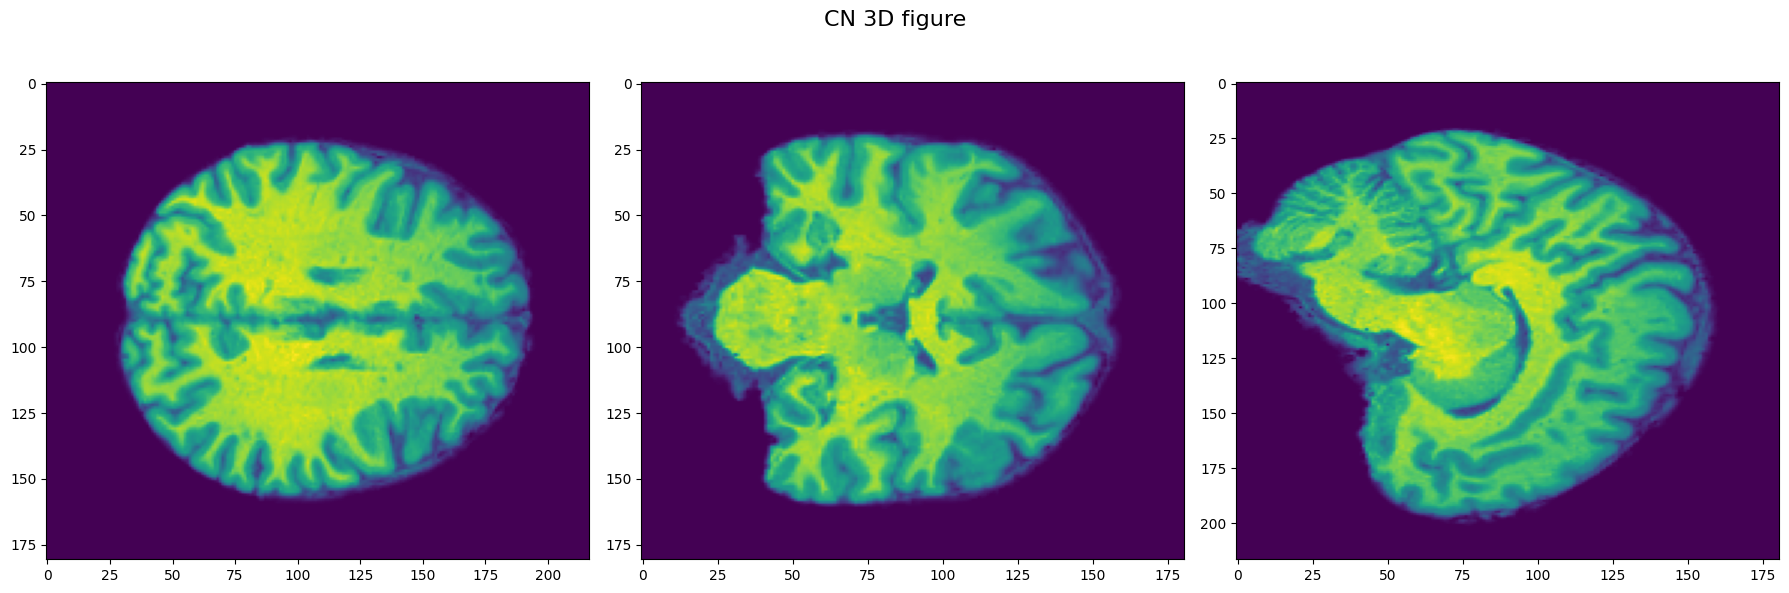

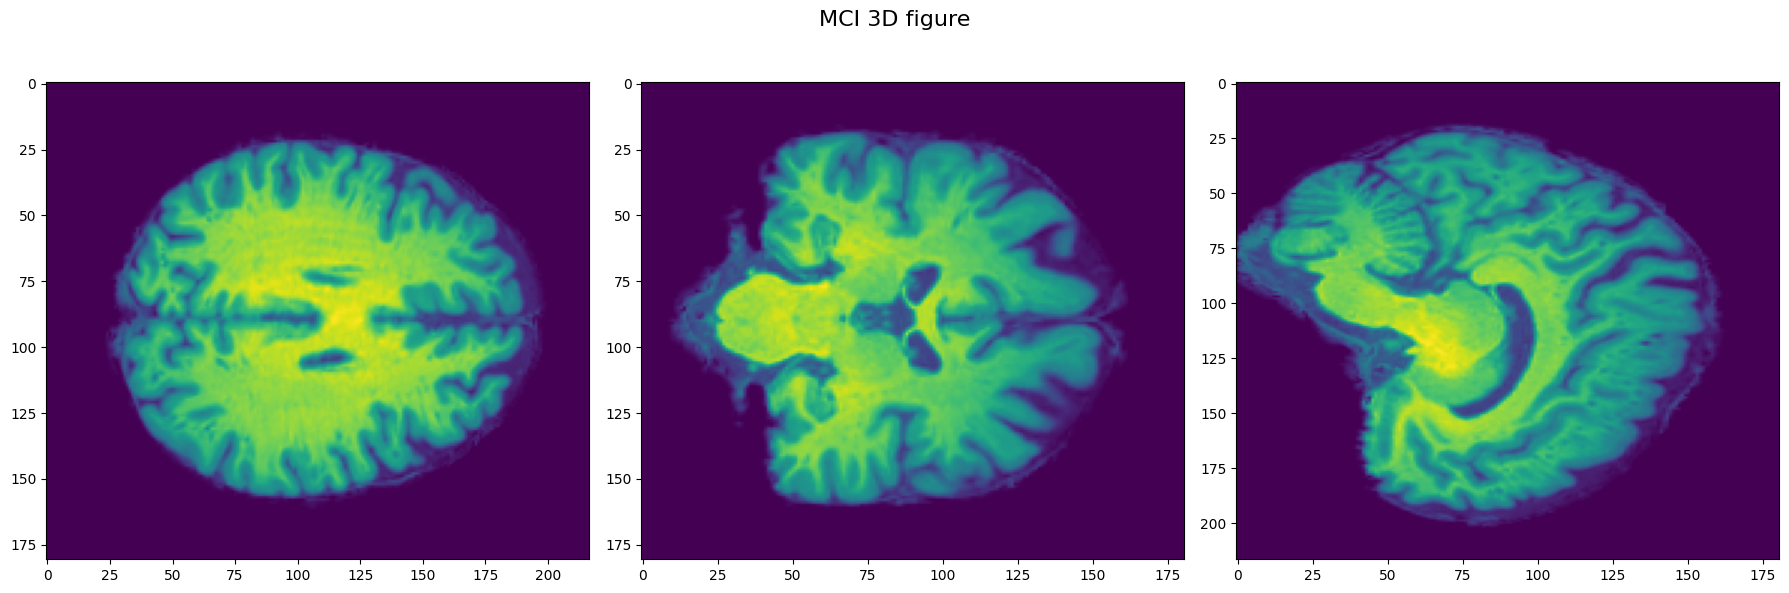

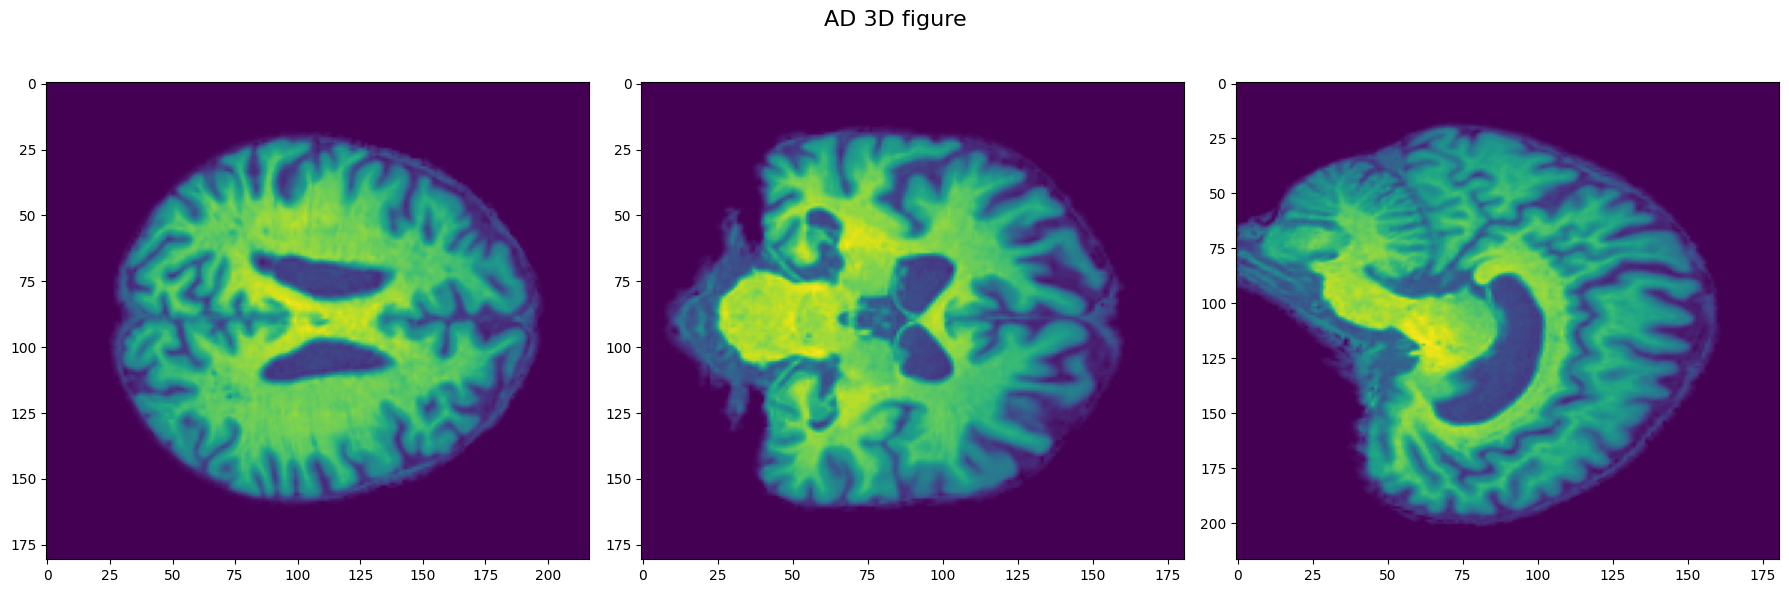

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(HC_3D_fmri[21][:,:,100], aspect='auto')
axes[1].imshow(HC_3D_fmri[21][:,100,:], aspect='auto')
axes[2].imshow(HC_3D_fmri[21][100,:,:], aspect='auto')

fig.suptitle('CN 3D figure', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()



fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(MCI_3D_fmri[31][:,:,100], aspect='auto')
axes[1].imshow(MCI_3D_fmri[31][:,100,:], aspect='auto')
axes[2].imshow(MCI_3D_fmri[31][100,:,:], aspect='auto')

fig.suptitle('MCI 3D figure', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()



fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(MCI_3D_fmri[20][:,:,100], aspect='auto')
axes[1].imshow(MCI_3D_fmri[20][:,100,:], aspect='auto')
axes[2].imshow(MCI_3D_fmri[20][100,:,:], aspect='auto')

fig.suptitle('AD 3D figure', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

In [60]:
mri_features = np.concatenate((np.array(resized_HC_fmri),np.array(resized_MCI_fmri)), axis=0)

In [61]:
mri_labels = np.concatenate((mri_labels_HC,mri_labels_MCI), axis=0)

In [62]:
x_size, y_size, z_size= mri_features[20].shape
mri_features[20].shape

(100, 108, 100)

In [63]:
x_train, x_te, y_train, y_te = train_test_split(mri_features,mri_labels,test_size=0.3,stratify=mri_labels)
x_val, x_test, y_val, y_test = train_test_split(x_te,y_te,test_size=0.5,stratify=y_te)

In [64]:
model = models.Sequential()

# Convolutional layers
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', input_shape=(x_size, y_size, z_size,1)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.3))
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dropout(0.3))

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [65]:
history_callback = History()
early_stopping = EarlyStopping(monitor='accuracy', patience=50, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=200, validation_data=(x_val, y_val),callbacks=[history_callback, early_stopping])
train_loss_values = history.history['loss']
train_acc_values = history.history['accuracy']
val_loss_values = history.history['val_loss']
val_acc_values = history.history['val_accuracy']


# Evaluate the model on the test set
val_loss, val_accuracy =  model.evaluate(x_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/200


4/4 [==============================] - 29s 6s/step - loss: 14736.0361 - accuracy: 0.4815 - val_loss: 9039.5488 - val_accuracy: 0.4348
Epoch 2/200
4/4 [==============================] - 27s 6s/step - loss: 7734.5098 - accuracy: 0.4444 - val_loss: 924127.1250 - val_accuracy: 0.5652
Epoch 3/200
4/4 [==============================] - 26s 6s/step - loss: 436951.4375 - accuracy: 0.5000 - val_loss: 12708.1143 - val_accuracy: 0.4348
Epoch 4/200
4/4 [==============================] - 27s 6s/step - loss: 20378.4863 - accuracy: 0.4444 - val_loss: 26559.7988 - val_accuracy: 0.4348
Epoch 5/200
4/4 [==============================] - 26s 6s/step - loss: 34451.5469 - accuracy: 0.4444 - val_loss: 36161.3555 - val_accuracy: 0.4348
Epoch 6/200
4/4 [==============================] - 27s 6s/step - loss: 42210.1250 - accuracy: 0.4444 - val_loss: 38882.6406 - val_accuracy: 0.4348
Epoch 7/200
4/4 [==============================] - 27s 6s/step - loss: 40905.5508 - accuracy: 0.4444 - val_loss: 317

1/1 [==============================] - 1s 1s/step


<Axes: >

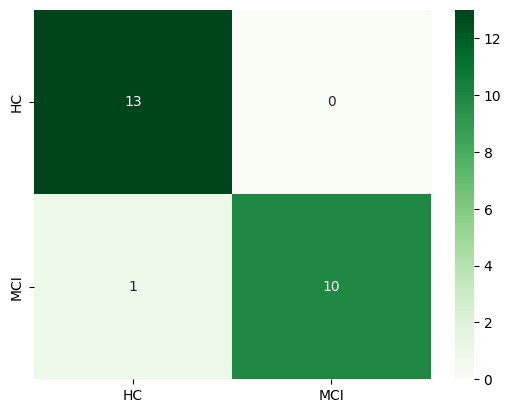

In [66]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
df = pd.DataFrame(data = confusion_matrix(y_test, predictions),
  columns = ['HC','MCI'],
  index = ['HC','MCI'])
sns.heatmap(df, cmap="Greens", annot=True, fmt='.0f')

<Axes: >

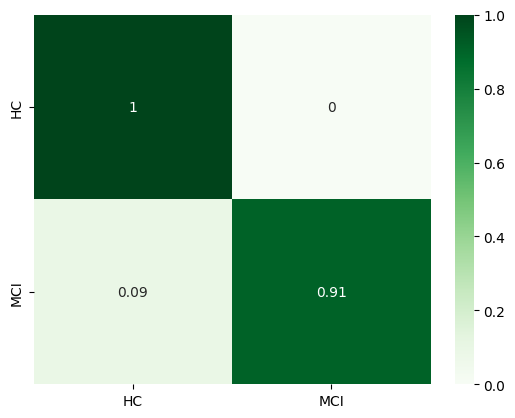

In [67]:
mat = confusion_matrix(y_test, predictions)
df =pd.DataFrame((mat/mat.sum(axis = 1,keepdims = True)).round(2), columns = ['HC','MCI'],index = ['HC','MCI'])
sns.heatmap(df, cmap="Greens", annot=True)

1/1 [==============================] - 1s 1s/step


<Axes: >

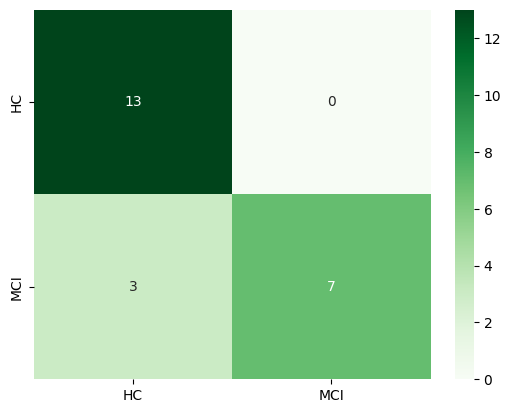

In [68]:
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
df = pd.DataFrame(data = confusion_matrix(y_val, predictions),
  columns = ['HC','MCI'],
  index = ['HC','MCI'])
sns.heatmap(df, cmap="Greens", annot=True, fmt='.0f')

<Axes: >

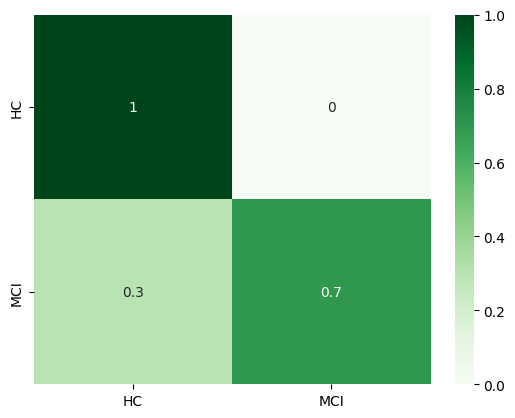

In [69]:
mat = confusion_matrix(y_val, predictions)
df =pd.DataFrame((mat/mat.sum(axis = 1,keepdims = True)).round(2), columns = ['HC','MCI'],index = ['HC','MCI'])
sns.heatmap(df, cmap="Greens", annot=True)

In [70]:
epochs_applied = early_stopping.stopped_epoch + 1
if epochs_applied<50:
    epochs_applied=200

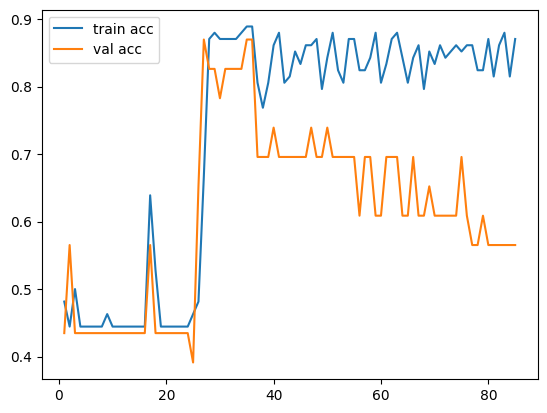

In [71]:
lenx = [i+1 for i in range(epochs_applied)]
plt.plot(lenx, train_acc_values, label = "train acc")
plt.plot(lenx, val_acc_values, label = "val acc")
plt.legend()
plt.show()

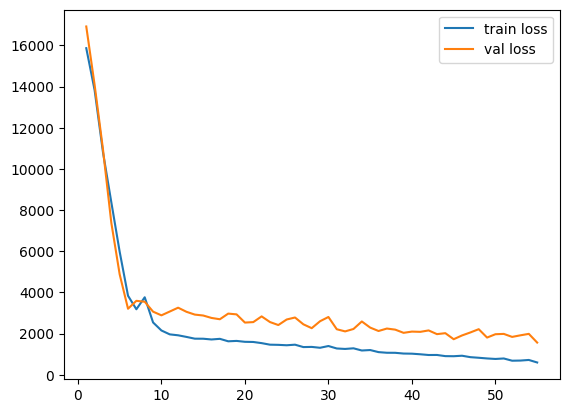

In [72]:
lenx = [i+1 for i in range(epochs_applied-30)]
plt.plot(lenx, train_loss_values[30:],label = "train loss")
plt.plot(lenx, val_loss_values[30:], label = "val loss")
plt.legend()
plt.show()

### Output each layer of the model

In [73]:
selected_img = 0
for i in range(len(y_train)):
    if y_train[i]==1:
        selected_img = x_train[i]
        break

1/1 [==============================] - 0s 67ms/step


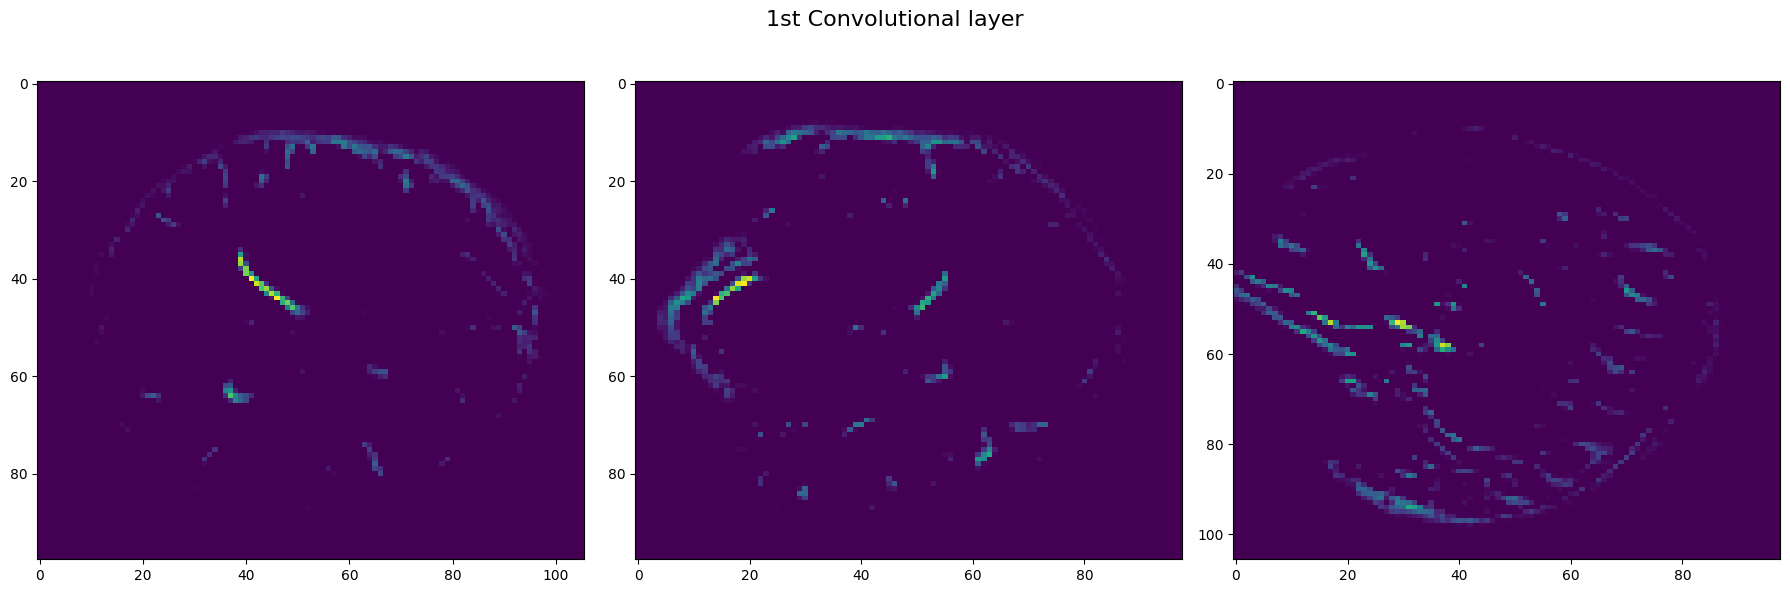

1/1 [==============================] - 0s 70ms/step


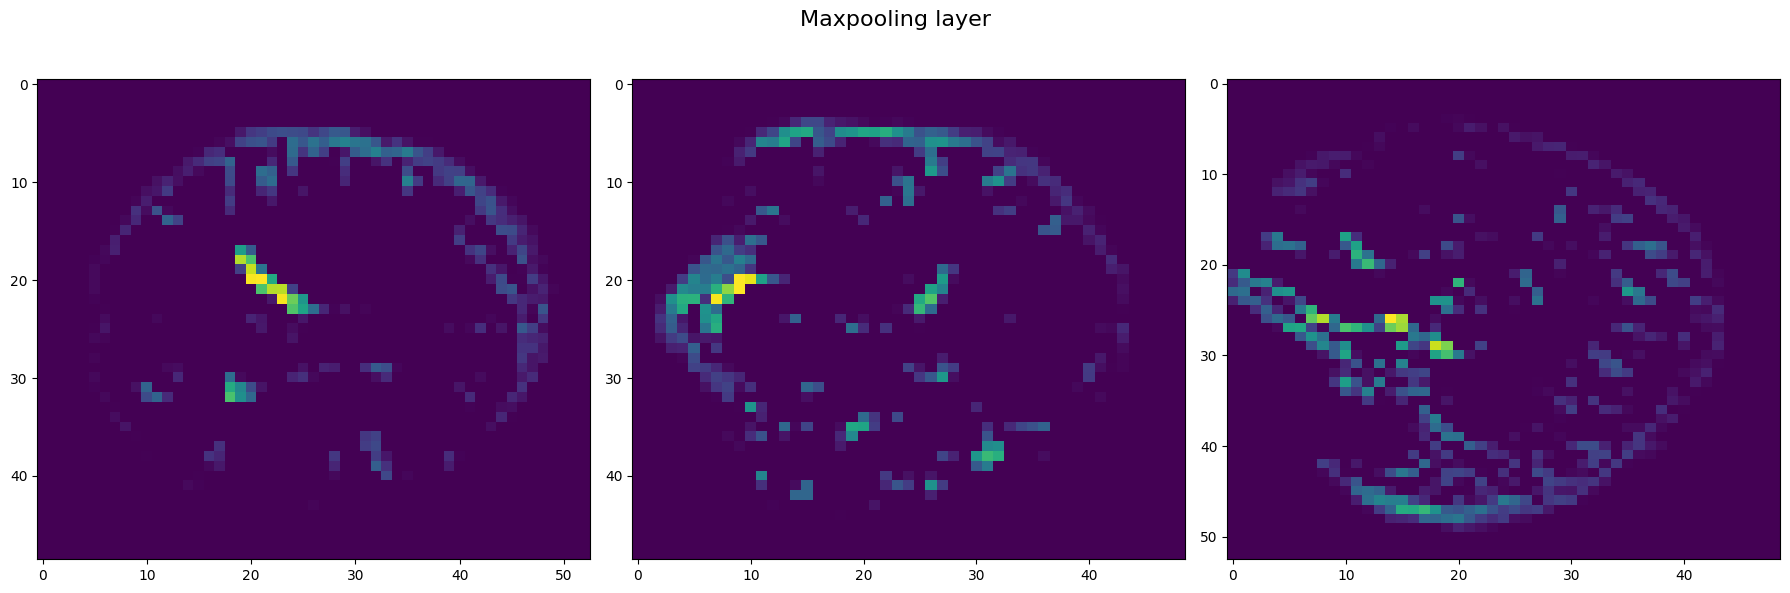

1/1 [==============================] - 0s 69ms/step


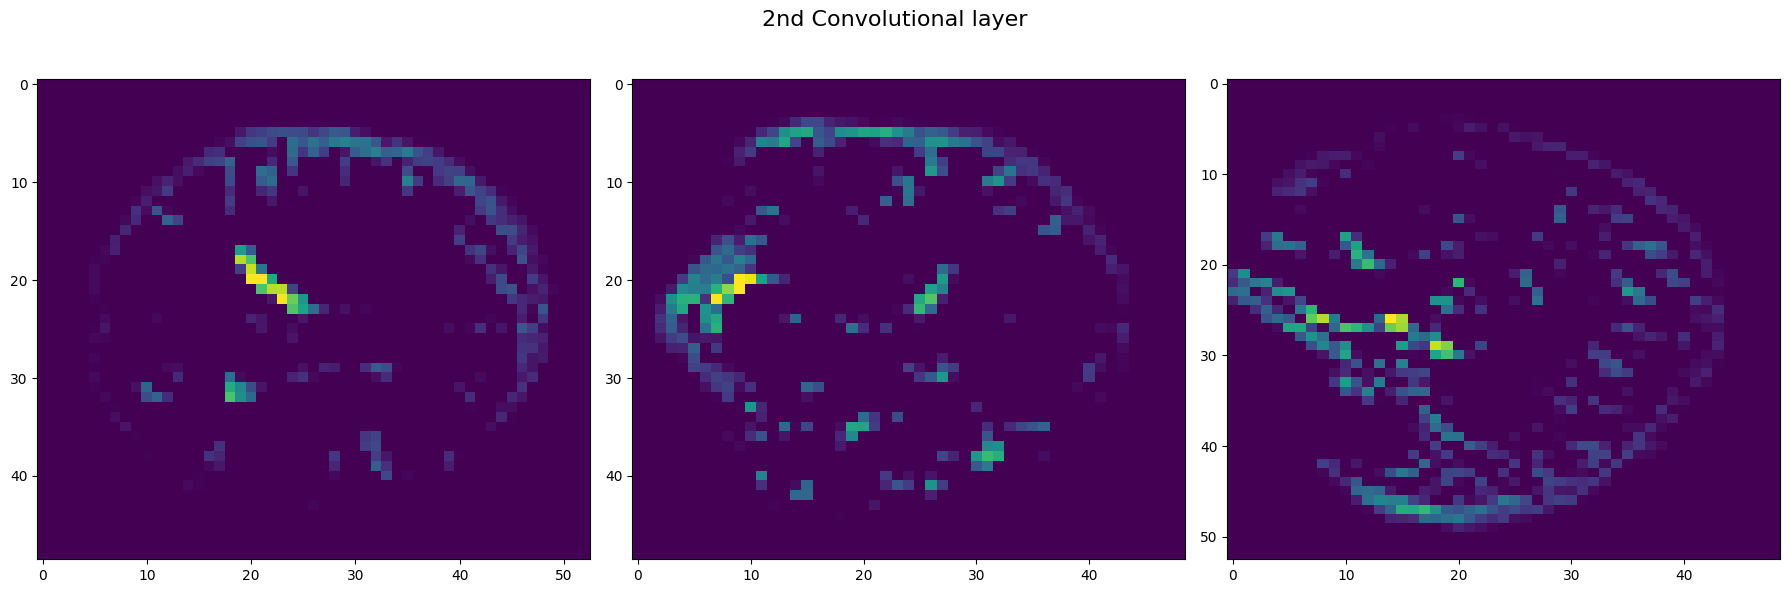

In [96]:
activation_model = models.Model(inputs=model.input, outputs=model.layers[0].output)


img_data = np.expand_dims(selected_img, axis=-1)  # Assuming your model input shape is (x_size, y_size, z_size, 1)
img_data = np.expand_dims(img_data, axis=0)  

# Get the activations of the convolutional layer
activations = activation_model.predict(img_data)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(activations[0,:,:,50,26], aspect='auto')
axes[1].imshow(activations[0,:,50,:,26], aspect='auto')
axes[2].imshow(activations[0,50,:,:,26], aspect='auto')

fig.suptitle('1st Convolutional layer', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


activation_model = models.Model(inputs=model.input, outputs=model.layers[1].output)


img_data = np.expand_dims(selected_img, axis=-1)  # Assuming your model input shape is (x_size, y_size, z_size, 1)
img_data = np.expand_dims(img_data, axis=0)  

# Get the activations of the convolutional layer
activations = activation_model.predict(img_data)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(activations[0,:,:,25,26], aspect='auto')
axes[1].imshow(activations[0,:,25,:,26], aspect='auto')
axes[2].imshow(activations[0,25,:,:,26], aspect='auto')

fig.suptitle('Maxpooling layer', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


activation_model = models.Model(inputs=model.input, outputs=model.layers[2].output)


img_data = np.expand_dims(selected_img, axis=-1)  # Assuming your model input shape is (x_size, y_size, z_size, 1)
img_data = np.expand_dims(img_data, axis=0)  

# Get the activations of the convolutional layer
activations = activation_model.predict(img_data)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(activations[0,:,:,25,26], aspect='auto')
axes[1].imshow(activations[0,:,25,:,26], aspect='auto')
axes[2].imshow(activations[0,25,:,:,26], aspect='auto')

fig.suptitle('2nd Convolutional layer', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

1/1 [==============================] - 0s 69ms/step


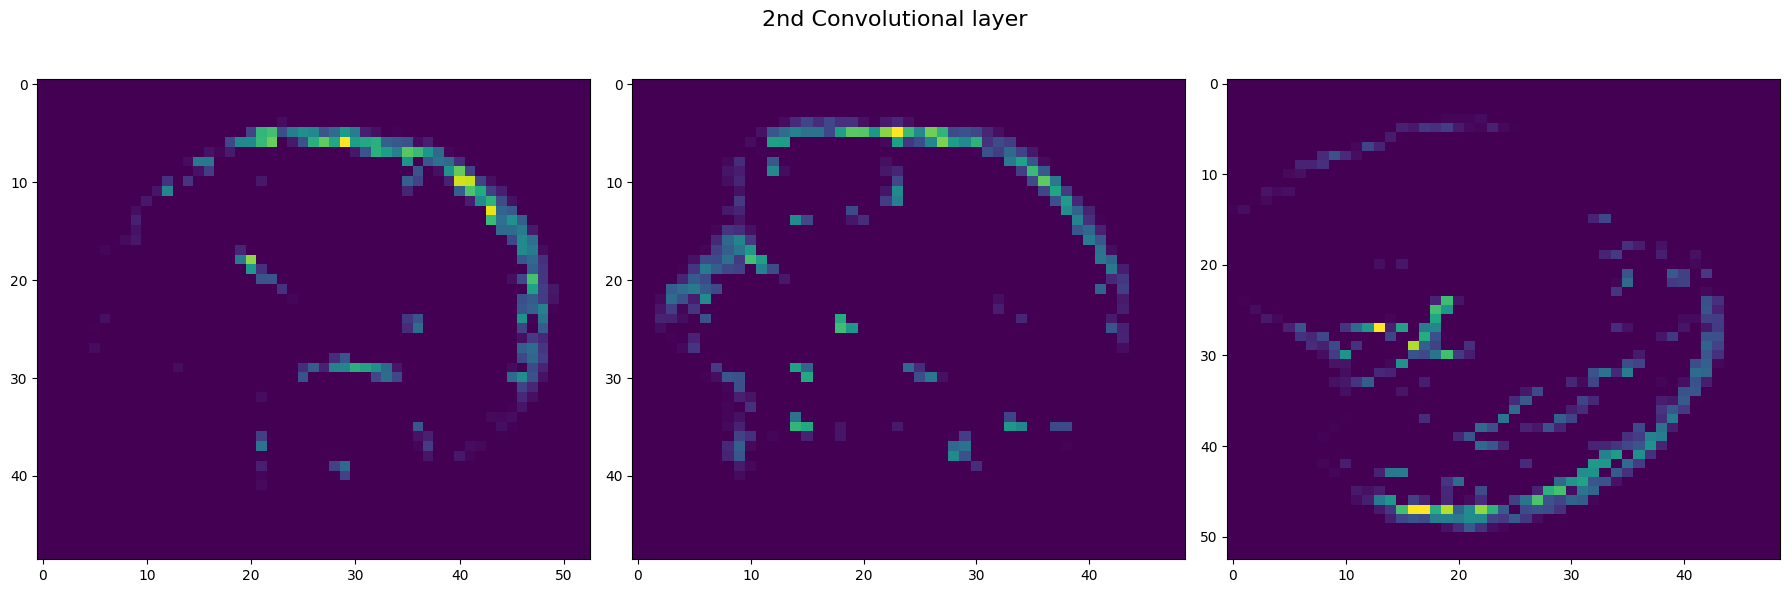

1/1 [==============================] - 0s 68ms/step


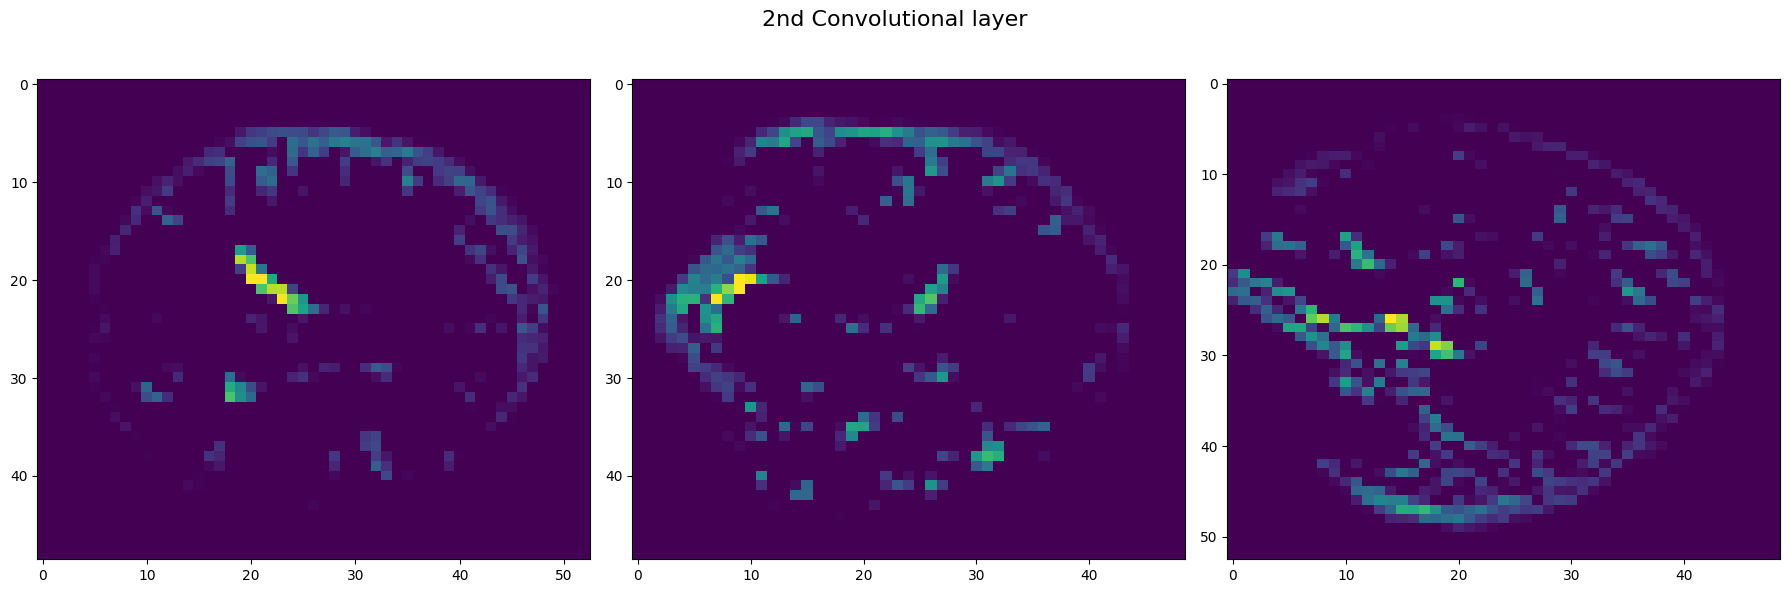

In [94]:
activation_model = models.Model(inputs=model.input, outputs=model.layers[2].output)


img_data = np.expand_dims(selected_img, axis=-1)  # Assuming your model input shape is (x_size, y_size, z_size, 1)
img_data = np.expand_dims(img_data, axis=0)  

# Get the activations of the convolutional layer
activations = activation_model.predict(img_data)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(activations[0,:,:,25,20], aspect='auto')
axes[1].imshow(activations[0,:,25,:,20], aspect='auto')
axes[2].imshow(activations[0,25,:,:,20], aspect='auto')

fig.suptitle('2nd Convolutional layer', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

activation_model = models.Model(inputs=model.input, outputs=model.layers[2].output)


img_data = np.expand_dims(selected_img, axis=-1)  # Assuming your model input shape is (x_size, y_size, z_size, 1)
img_data = np.expand_dims(img_data, axis=0)  

# Get the activations of the convolutional layer
activations = activation_model.predict(img_data)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(activations[0,:,:,25,26], aspect='auto')
axes[1].imshow(activations[0,:,25,:,26], aspect='auto')
axes[2].imshow(activations[0,25,:,:,26], aspect='auto')

fig.suptitle('2nd Convolutional layer', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

### Deconvolution (Reconstruction)

1/1 [==============================] - 0s 57ms/step


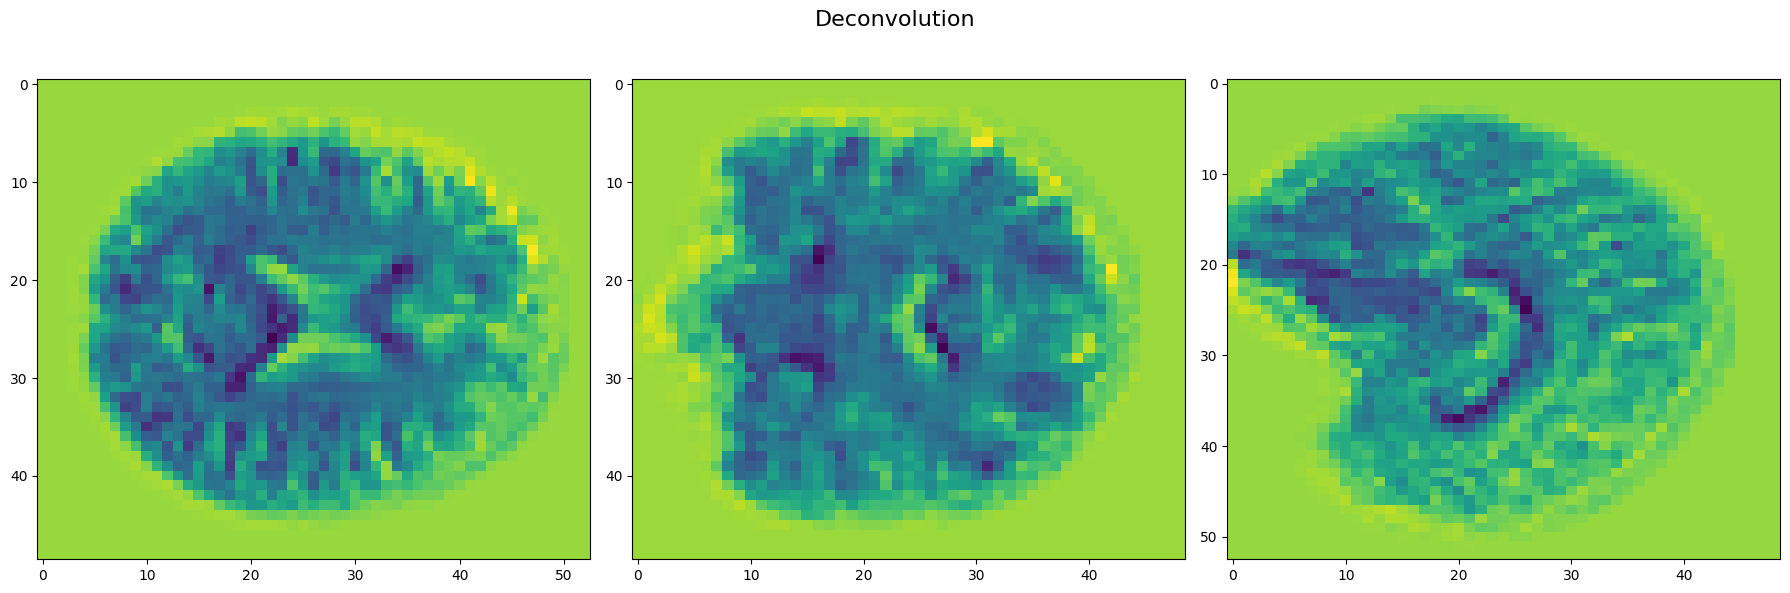

In [150]:
activation_shape = activations.shape[1:]

# Define the deconvolution model
input_layer = Input(shape=activation_shape)
deconv_layer = Conv3DTranspose(filters=1, kernel_size=(3,3,3), strides=(1,1,1), padding='same')(input_layer)
deconv_model = Model(inputs=input_layer, outputs=deconv_layer)

# Get the deconvolution result
deconv_output = deconv_model.predict(activations)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(deconv_output[0,:,:,25], aspect='auto')
axes[1].imshow(deconv_output[0,:,25,:], aspect='auto')
axes[2].imshow(deconv_output[0,25,:,:], aspect='auto')

fig.suptitle('Deconvolution', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()